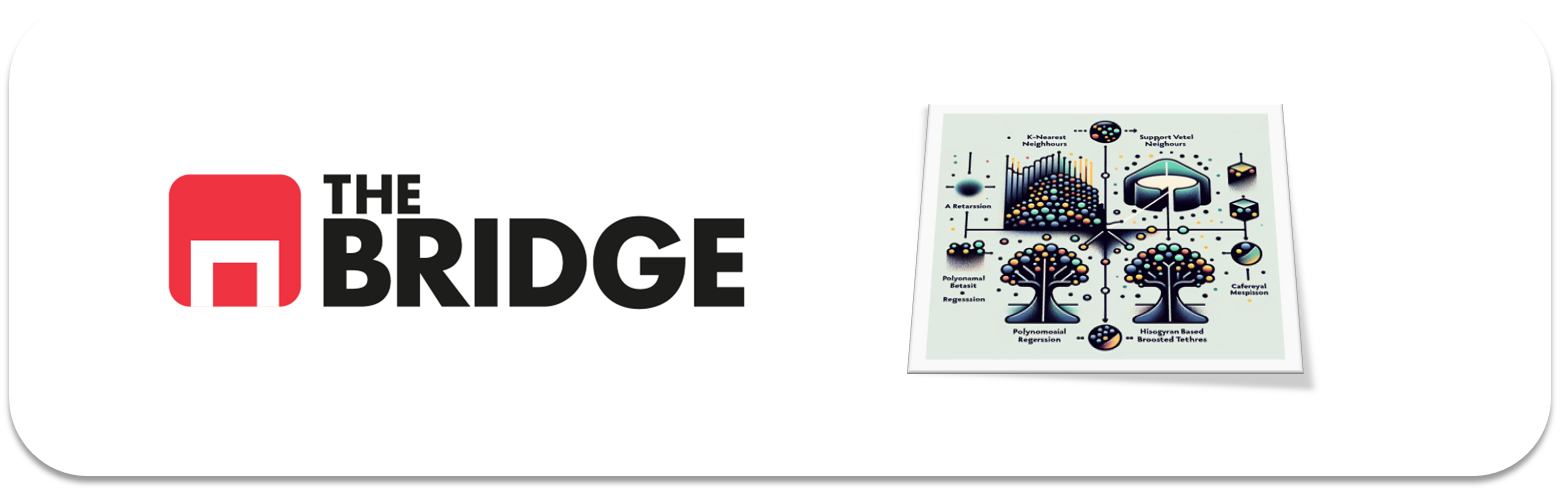

## PRACTICA OBLIGATORIA: **Repaso Aprendizaje Supervisado**

* La práctica obligatoria de esta unidad consiste en resolver sobre un mismo dataset un problema de clasificación y un problema de regresión. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMClassifier
from sklearn import linear_model, metrics, model_selection
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay, mean_absolute_error, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier

### #1 Explicación del dataset y carga de datos

Vamos a trabajar con el dataset "Wine Quality", que es un dataset en el que se recogen diversas características fisicoquímicas de las variades tinta y blanca del "Vinho verde" portugués. Las variables del dataset se describen a continuación


1. **Acidez fija**: La mayoría de los ácidos involucrados con el vino son fijos o no volátiles (no se evaporan fácilmente).
2. **Acidez volátil**: La cantidad de ácido acético en el vino, que en niveles demasiado altos puede llevar a un sabor desagradable a vinagre.
3. **Ácido cítrico**: Encontrado en pequeñas cantidades, el ácido cítrico puede añadir 'frescura' y sabor a los vinos.
4. **Azúcar residual**: Es la cantidad de azúcar restante después de que se detiene la fermentación, es raro encontrar vinos con menos de 1 gramo/litro y vinos con más de 45 gramos/litro se consideran dulces.
5. **Cloruros**: La cantidad de sal en el vino.
6. **Dióxido de azufre libre**: La porción libre de SO2 existe en equilibrio entre el SO2 molecular (como un gas disuelto) y el ion bisulfito; previene el crecimiento microbiano y la oxidación del vino.
7. **Dióxido de azufre total**: Es la cantidad de formas libres y ligadas de S02; en bajas concentraciones, el SO2 es en su mayoría indetectable en el vino, pero en concentraciones libres de más de 50 ppm, el SO2 se hace evidente en la nariz y el sabor del vino.
8. **Densidad**: La densidad del vino es cercana a la del agua dependiendo del porcentaje de alcohol y contenido de azúcar.
9. **pH**: Describe qué tan ácido o básico es un vino en una escala de 0 (muy ácido) a 14 (muy básico); la mayoría de los vinos están entre 3-4 en la escala de pH.
10. **Sulfatos**: Un aditivo del vino que puede contribuir a los niveles de dióxido de azufre (SO2), que actúa como un antimicrobiano y antioxidante.
11. **Alcohol**: El porcentaje de contenido de alcohol del vino.
12. **Calidad**: Una variable de salida (basada en datos sensoriales, puntuación entre 0 y 10).
13. **Class**: Si es blanco o tinto.



Carga el dataset "wines_dataset.csv", muestra sus primeras filas, su información general y define dos variables target una para clasificación que permita predecir la calidad del vino según el resto de propiedas y otra variable target para regresión que permita predecir el grado alcohólico del vino a partir del resto de propiedades. 

El **objetivo de negocio en el primer problema** será anticipar la posible clasificación de sus vinos por los catadores profesionales y a partir de ahí poder planificar la producción, distribución y precio a poner a cada vino. En este sentido, el "cliente" nos dice que le gustaría poder clasificar correctamente lo mejor posible en media  (que interpretamos como el mejor recall medio posible).

El **objetivo de negocio en el segundo problema** (bastante artificial) es poder hacer simulaciones de posibles vinos futuros para saber cómo conseguir variedades más o menos alcohólicas para atender mercados diferentes. En este sentido, les interesa equivocarse lo menos posible porcentualmente sobre el grado alochólico real.

Muestra la distribución de ambos targets y haz un pequeño assesment previo de cada problema. NOTA: El dataset está limpio y sin valores faltantes.

In [590]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [591]:
df.head(10)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.5             0.210         0.26            9.25      0.034   
1            8.3             0.160         0.37            7.90      0.025   
2            6.8             0.180         0.38            1.40      0.038   
3            6.1             0.260         0.25            2.90      0.047   
4            7.5             0.630         0.27            2.00      0.083   
5            5.7             0.265         0.28            6.90      0.036   
6            6.6             0.210         0.31           11.40      0.039   
7            6.7             0.310         0.30            2.10      0.038   
8            8.9             0.750         0.14            2.50      0.086   
9            7.5             0.420         0.20            1.40      0.060   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 73.0                 142.0  0.99450  3.05       0.37   
1                 38.0                 107.0  0.99306  2.93       0.37   
2                 35.0                 111.0  0.99180  3.32       0.59   
3                289.0                 440.0  0.99314  3.44       0.64   
4                 17.0                  91.0  0.99616  3.26       0.58   
5                 46.0                 150.0  0.99299  3.36       0.44   
6                 46.0                 165.0  0.99795  3.41       0.44   
7                 18.0                 130.0  0.99280  3.36       0.63   
8                  9.0                  30.0  0.99824  3.34       0.64   
9                 15.0                 168.0  0.99440  3.06       0.40   

   alcohol  quality  class  
0     11.4        6  white  
1     11.9        6  white  
2     11.2        7  white  
3     10.5        3  white  
4      9.8        6    red  
5     10.8        7  white  
6      9.8        7  white  
7     10.6        6  white  
8     10.5        5    red  
9      9.4        6  white

In [592]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  class                 6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [593]:
df.describe().T

count        mean        std      min       25%  \
fixed acidity         6497.0    7.215307   1.296434  3.80000   6.40000   
volatile acidity      6497.0    0.339666   0.164636  0.08000   0.23000   
citric acid           6497.0    0.318633   0.145318  0.00000   0.25000   
residual sugar        6497.0    5.443235   4.757804  0.60000   1.80000   
chlorides             6497.0    0.056034   0.035034  0.00900   0.03800   
free sulfur dioxide   6497.0   30.525319  17.749400  1.00000  17.00000   
total sulfur dioxide  6497.0  115.744574  56.521855  6.00000  77.00000   
density               6497.0    0.994697   0.002999  0.98711   0.99234   
pH                    6497.0    3.218501   0.160787  2.72000   3.11000   
sulphates             6497.0    0.531268   0.148806  0.22000   0.43000   
alcohol               6497.0   10.491801   1.192712  8.00000   9.50000   
quality               6497.0    5.818378   0.873255  3.00000   5.00000   

                            50%        75%        max  
fixed acidity           7.00000    7.70000   15.90000  
volatile acidity        0.29000    0.40000    1.58000  
citric acid             0.31000    0.39000    1.66000  
residual sugar          3.00000    8.10000   65.80000  
chlorides               0.04700    0.06500    0.61100  
free sulfur dioxide    29.00000   41.00000  289.00000  
total sulfur dioxide  118.00000  156.00000  440.00000  
density                 0.99489    0.99699    1.03898  
pH                      3.21000    3.32000    4.01000  
sulphates               0.51000    0.60000    2.00000  
alcohol                10.30000   11.30000   14.90000  
quality                 6.00000    6.00000    9.00000

In [594]:
target_clasificacion = "quality"
target_regresion = "alcohol"

### #2 Modelado para clasificación

Crea un modelo que permita clasificar lo mejor posible los vinos en función de su calidad, o dicho de otro modo que prediga de la mejor manera posible la calidad de un vino a partir de sus propiedades químicas. ***Considéralo un problema de clasificación***, donde los valores de calidad son las clases a predecir. Puedes utilizar los modelos que creas conveniente, al menos tres, y utiliza un KNN como modelo baseline, prueba al menos con 2 valores de K. Intenta mejorar el "recall medio" con las técnicas que creas conveniente. Compara los modelos utilizando validación cruzada con o sin optimización previa de hiperparámetros (aunque en la sesión en vivo por limitación de tiempos sólo lo haremos con validación cruzada). El modelo elegido si tiene que tener un ejemplo de optimización de parámetros.

Evalúa el modelo, analiza los errores y propón algún mecanismo de mejora aunque sea sólo un esbozo.

In [595]:
#primiero transformo los string en binaria porque me va a dar menos trabajo
# Convertir la columna "class" a valores numéricos
df["class"] = df["class"].map({"red": 1, "white": 0})

# Verificar la transformación
print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            8.5              0.21         0.26            9.25      0.034   
1            8.3              0.16         0.37            7.90      0.025   
2            6.8              0.18         0.38            1.40      0.038   
3            6.1              0.26         0.25            2.90      0.047   
4            7.5              0.63         0.27            2.00      0.083   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 73.0                 142.0  0.99450  3.05       0.37   
1                 38.0                 107.0  0.99306  2.93       0.37   
2                 35.0                 111.0  0.99180  3.32       0.59   
3                289.0                 440.0  0.99314  3.44       0.64   
4                 17.0                  91.0  0.99616  3.26       0.58   

   alcohol  quality  class  
0     11.4        6      0  
1     11.9        6      0  

In [596]:
#Split
train_set_clasificacion, test_set_clasificacion = train_test_split(df, test_size= 0.2, random_state= 42)

C:\Users\sheir\AppData\Local\Temp\ipykernel_31896\2998394650.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_set_clasificacion["quality"], palette="viridis")


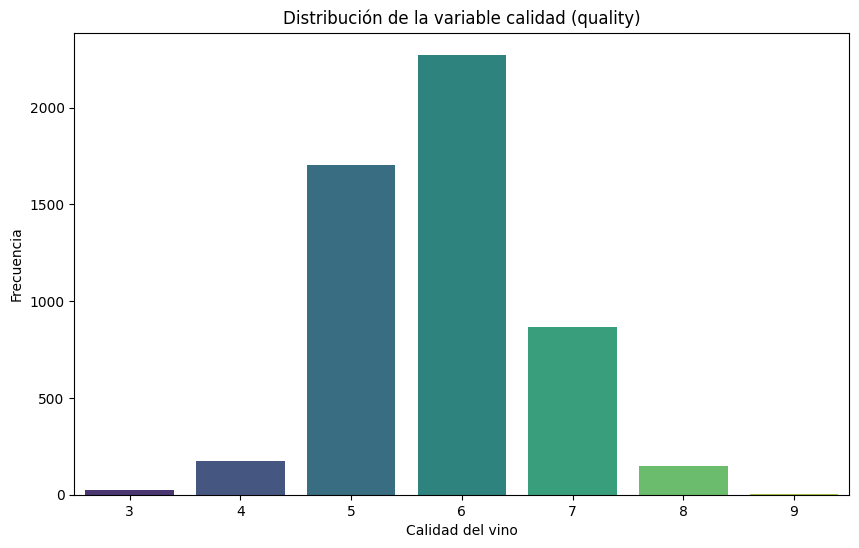

In [597]:
#MiniEDA target_clasificación

plt.figure(figsize=(10,6))
sns.countplot(x=train_set_clasificacion["quality"], palette="viridis")

plt.title("Distribución de la variable calidad (quality)")
plt.xlabel("Calidad del vino")
plt.ylabel("Frecuencia")
plt.show()

Tiene una distribución muy parecida a la normal con los máximos valores de frecuencia en el centro y menores en los extremos.

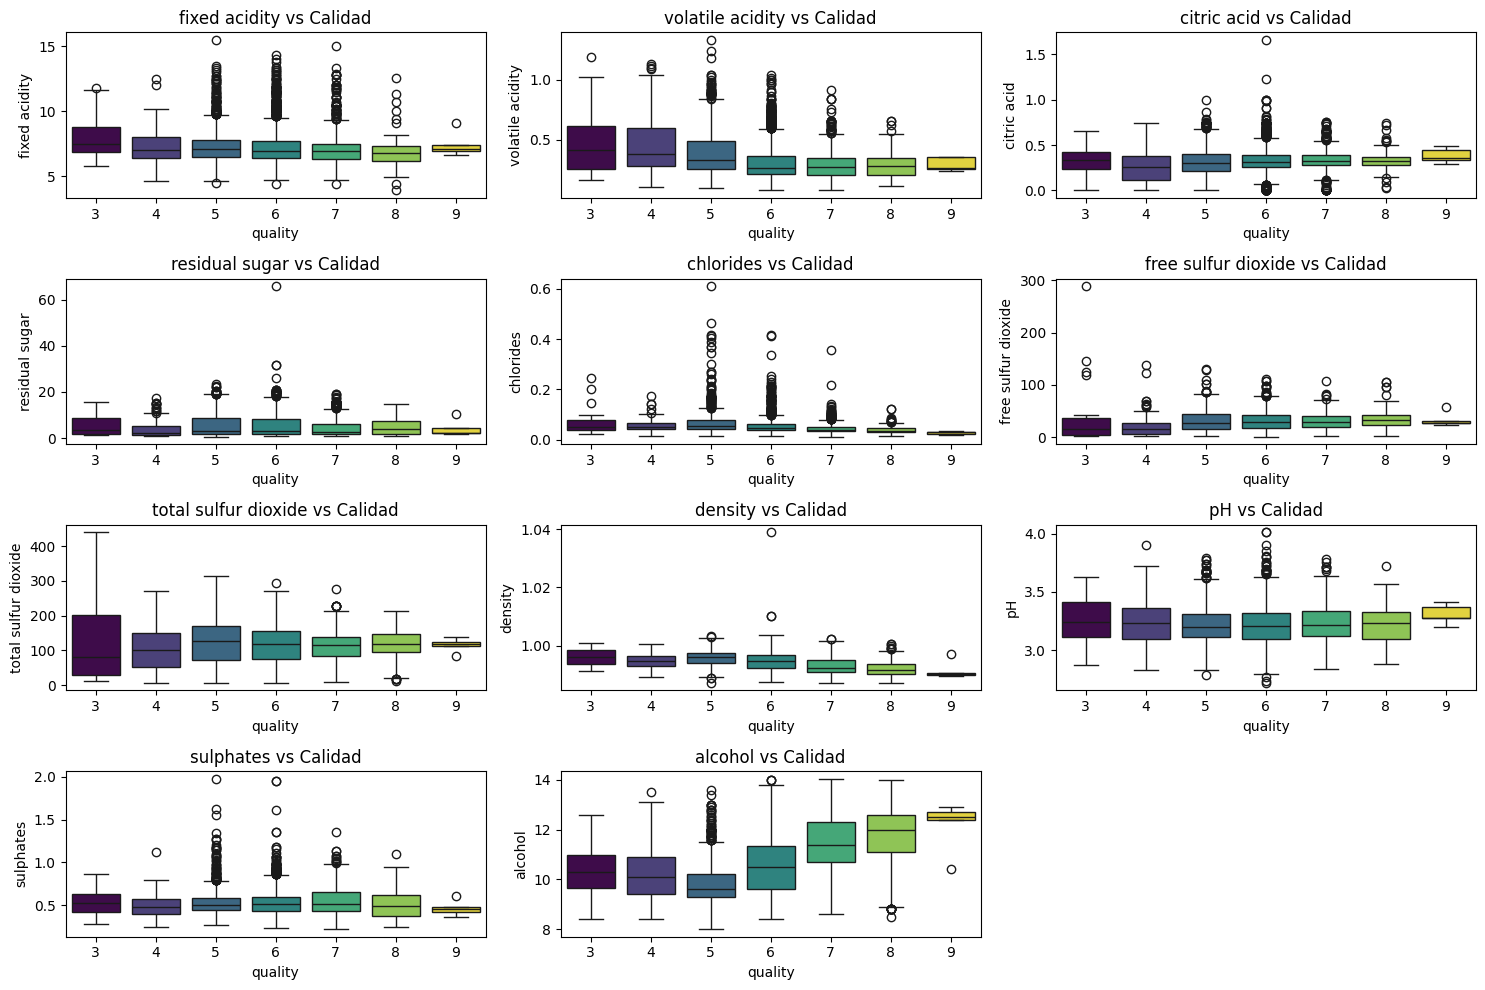

In [598]:
#MiniEDA features_clasificación

features_num_clasificacion = [
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar",
    "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density",
    "pH", "sulphates", "alcohol"
]
features_cat_clasificacion = ["class"]  # En este caso solo 'class' es categórica

plt.figure(figsize=(15,10))
for i, col in enumerate(features_num_clasificacion):
    plt.subplot(4, 3, i+1)
    sns.boxplot(x="quality", y=col, data=train_set_clasificacion, hue="quality", palette="viridis", legend=False)
    plt.title(f"{col} vs Calidad")
plt.tight_layout()
plt.show()

Veo la distribución de las features numéricas (del dataset inicial):

(11, 2)


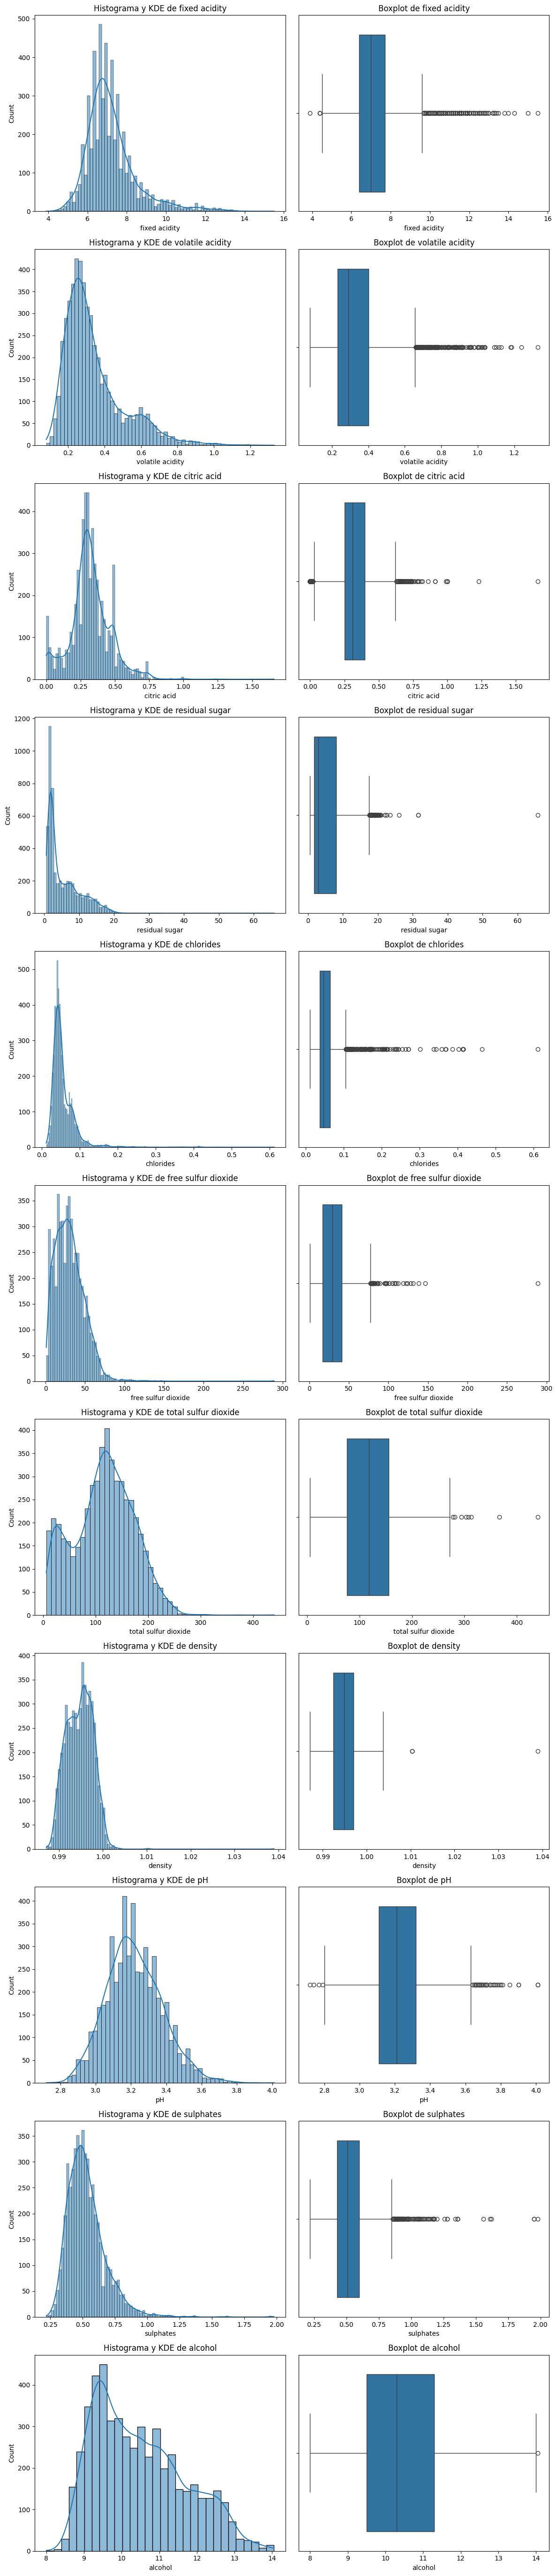

In [599]:
bt.plot_combined_graphs(train_set_clasificacion, features_num_clasificacion, whisker_width=1.5, bins = None)



Vamos a tener que normalizar con logaritmo: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, sulphates y alcohol. pH yo no la tocaría.

La distribución de la feature categórica

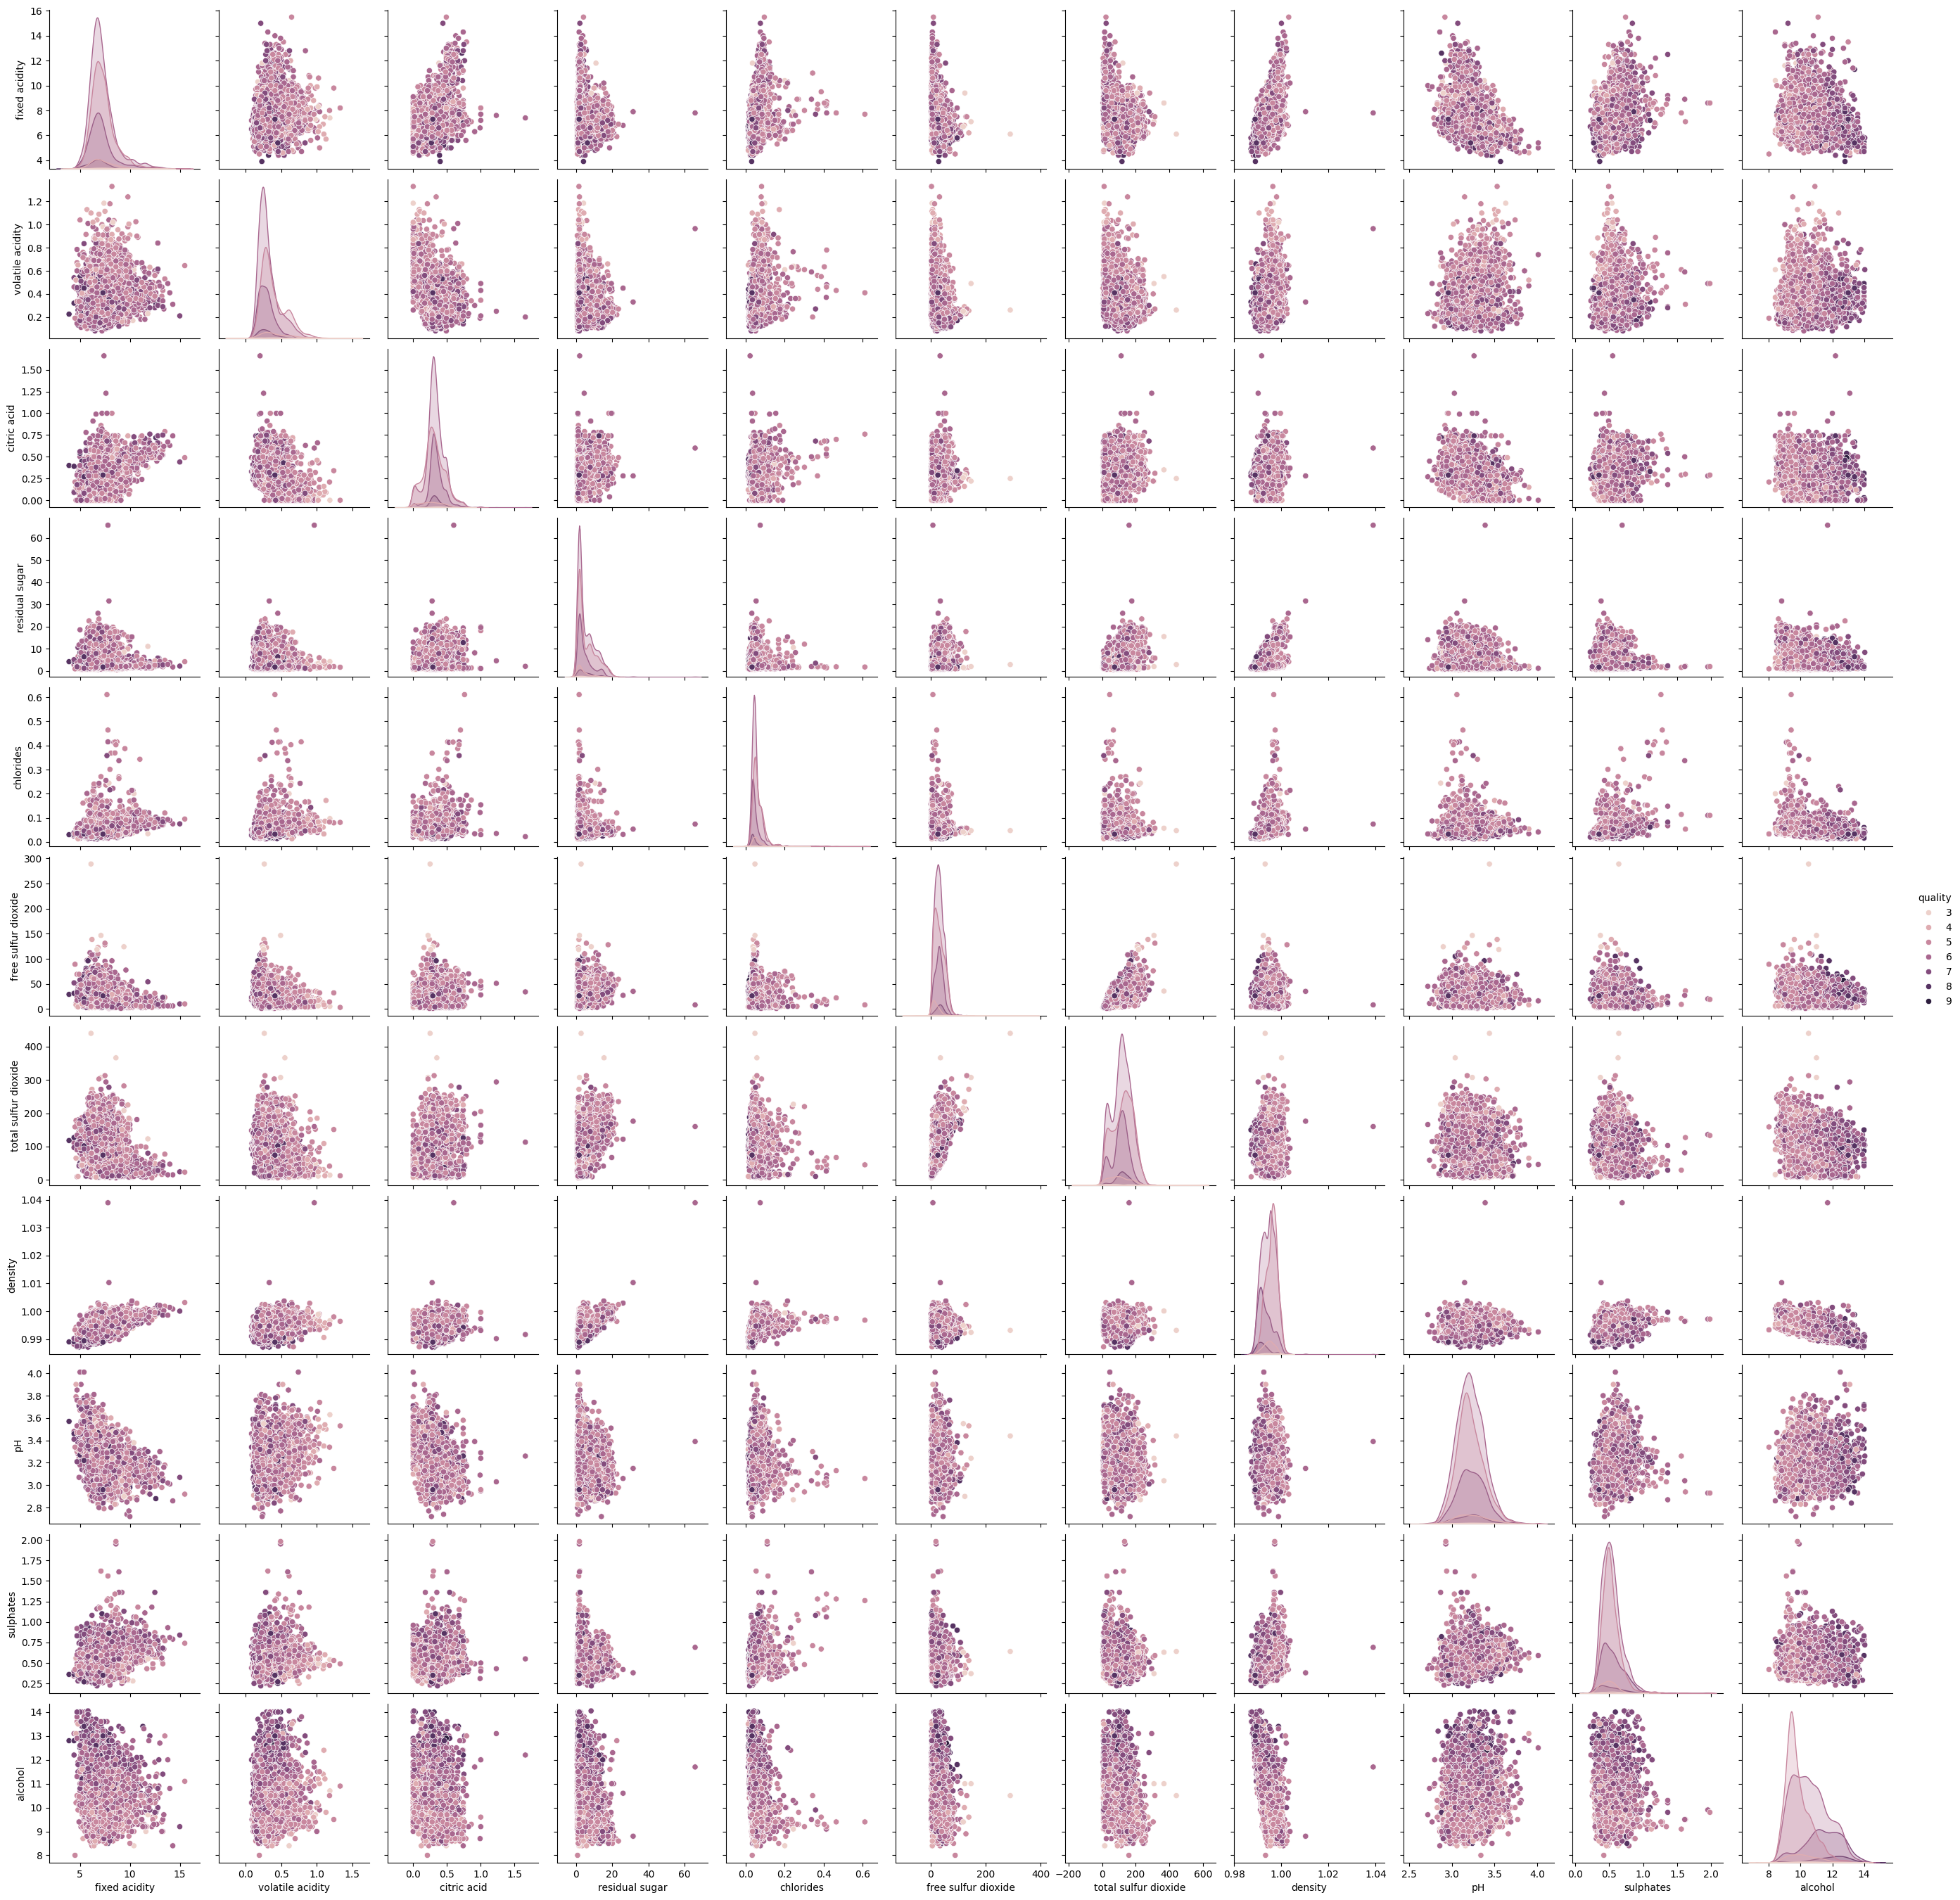

In [600]:
# Varios pairplot de seaborn, con el hue asignado a la variable target. Varios porque son muchas
sns.pairplot(train_set_clasificacion[features_num_clasificacion + ["quality"]], hue = "quality")

Fixed acidity: parece ue hay solapamiento entre las distintas clases de calidad lo que quiere decir que las diferencias entre niveles no son significativas respecto de la acided fija. Se podrían agrupar las calidades en baja calidad (para categorías 3 y 4), media calidad (para 5 y 6) y alta calidad para 7, 8 y 9.  
Volatile acidity: Se nota una diferencia más clara en algunas clases de calidad. En general los vinos de baja calidad tiene más acidez volátil.  
Citric acid: La mayoría de vinos con valores altos de ácido cítrico están en las calidades medias. Los vinos mejor calificados parecen tener un factor muy bajo.  
La mayor parte de los vinos medios y buenos tiene bajo azúcar residual.  
Los vinos suelen tener bajos niveles de cloruros cuyo pico se concentra en los vinos de más baja calidad.  



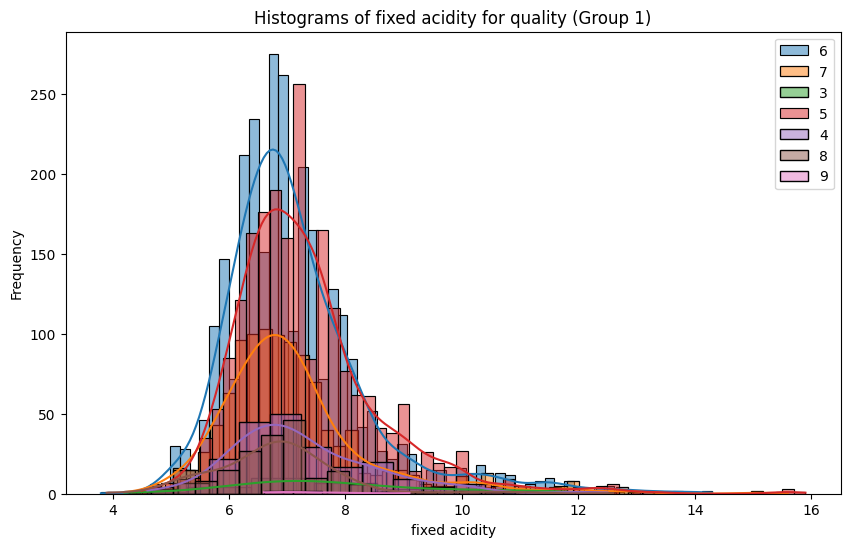

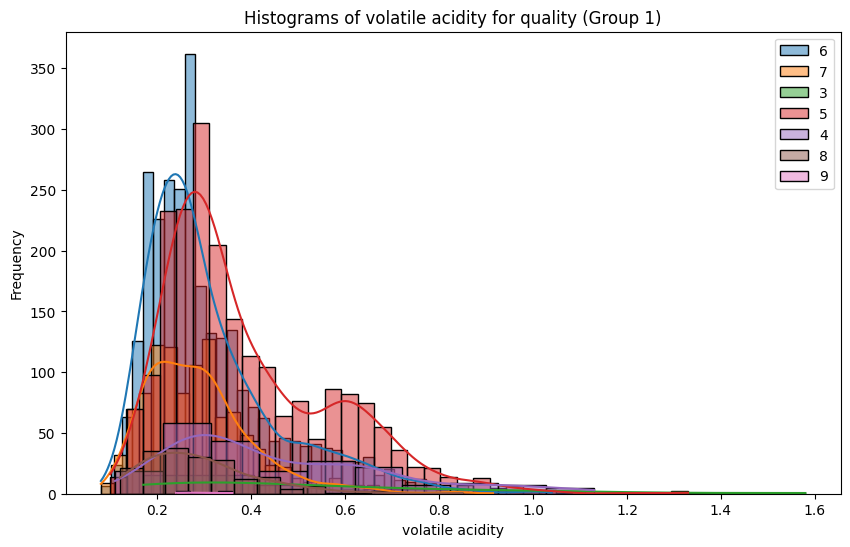

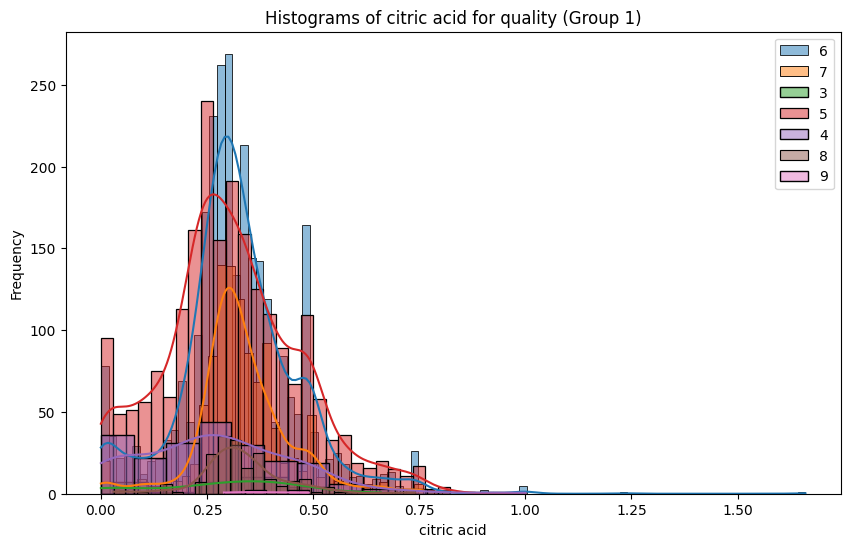

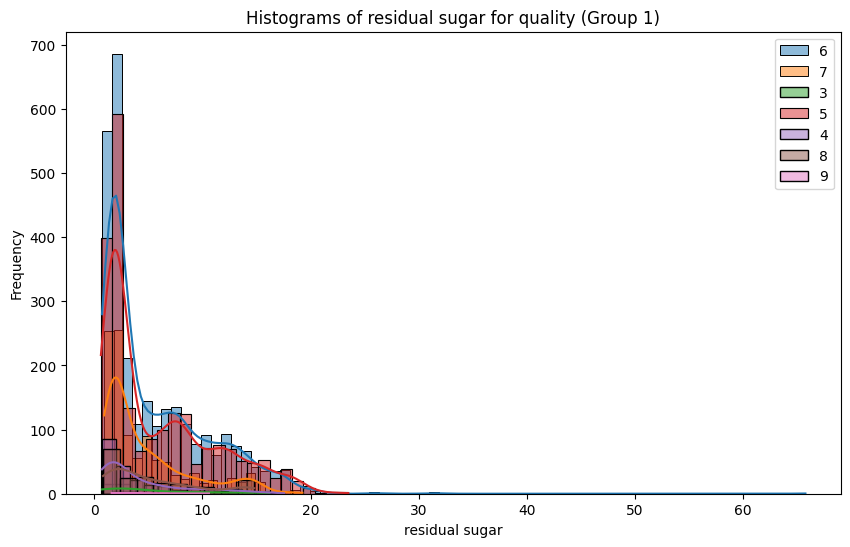

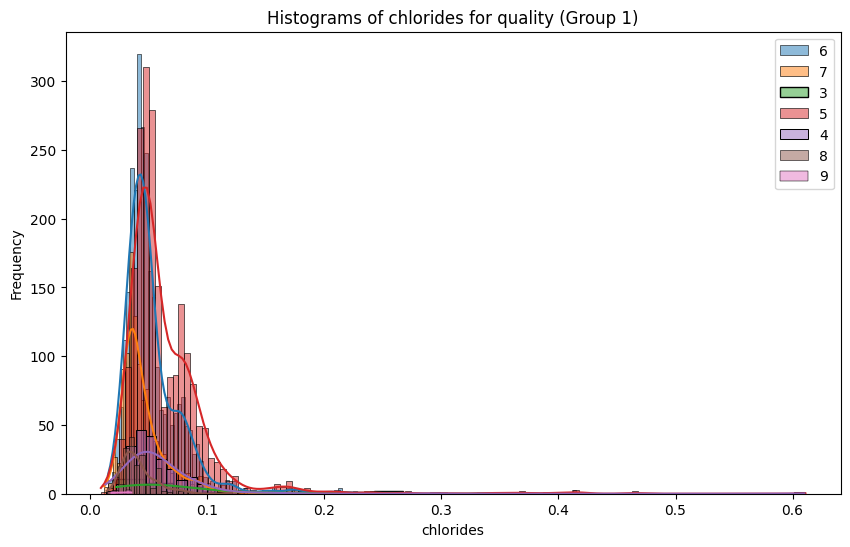

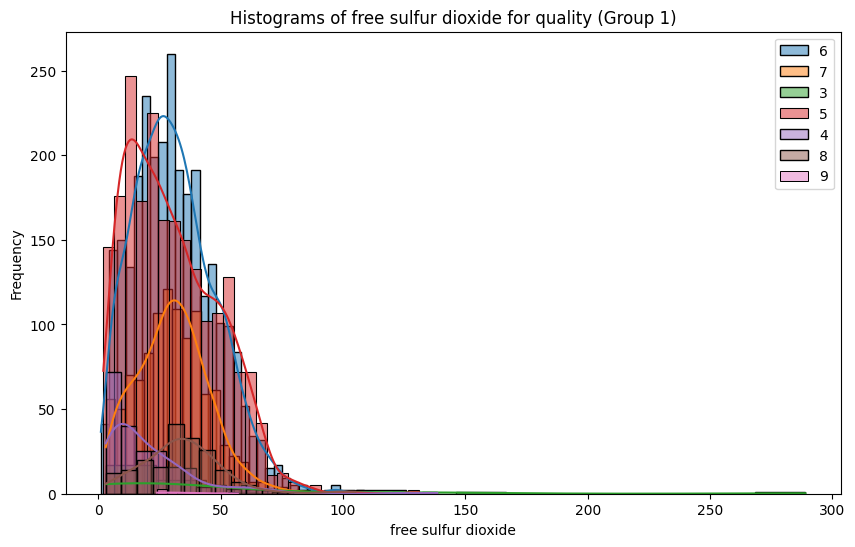

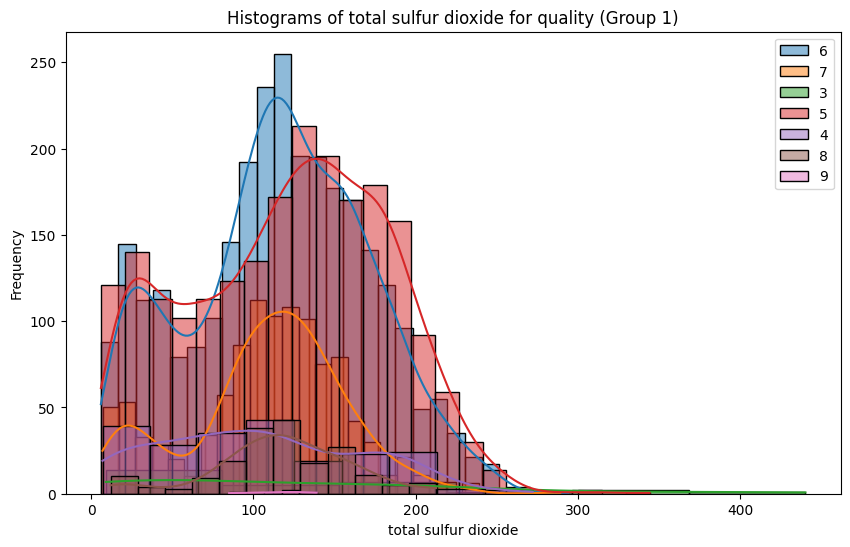

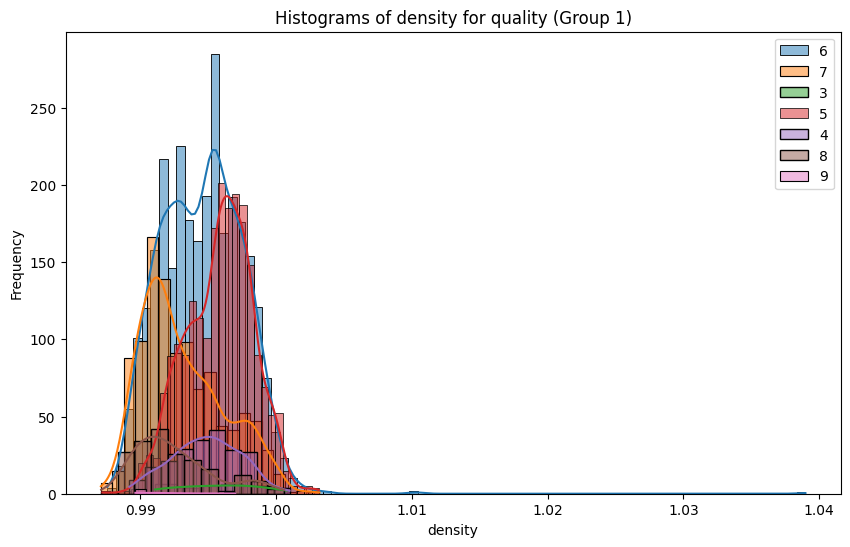

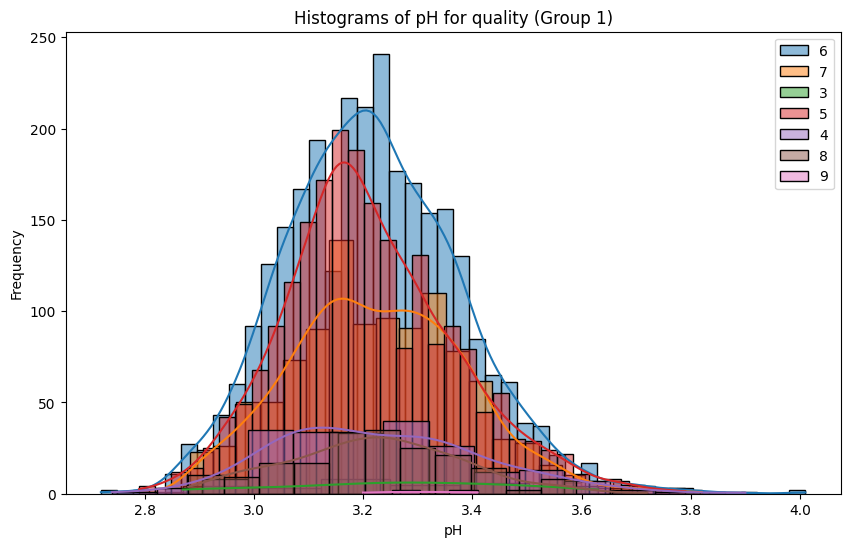

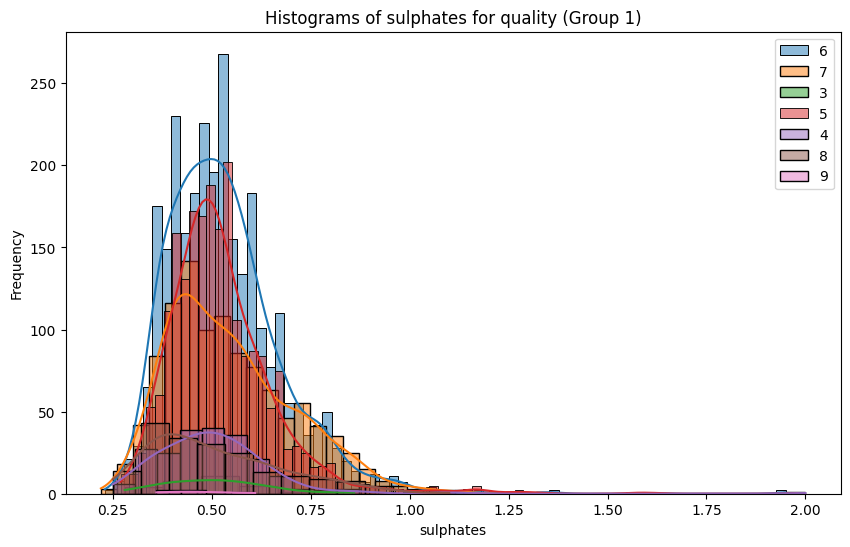

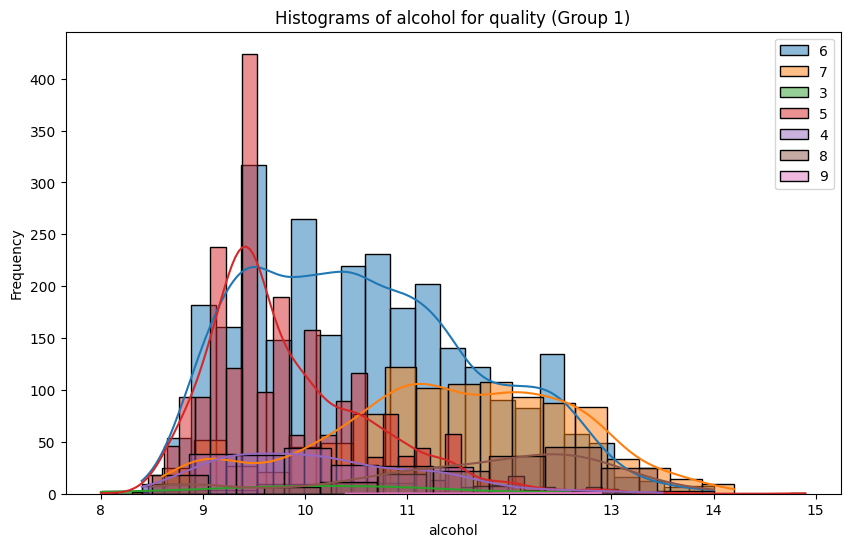

In [601]:
# gráfico de dispersión con correlación
for col in features_num_clasificacion:
    bt.plot_grouped_histograms(df, cat_col = "quality", num_col = col, group_size = 7)

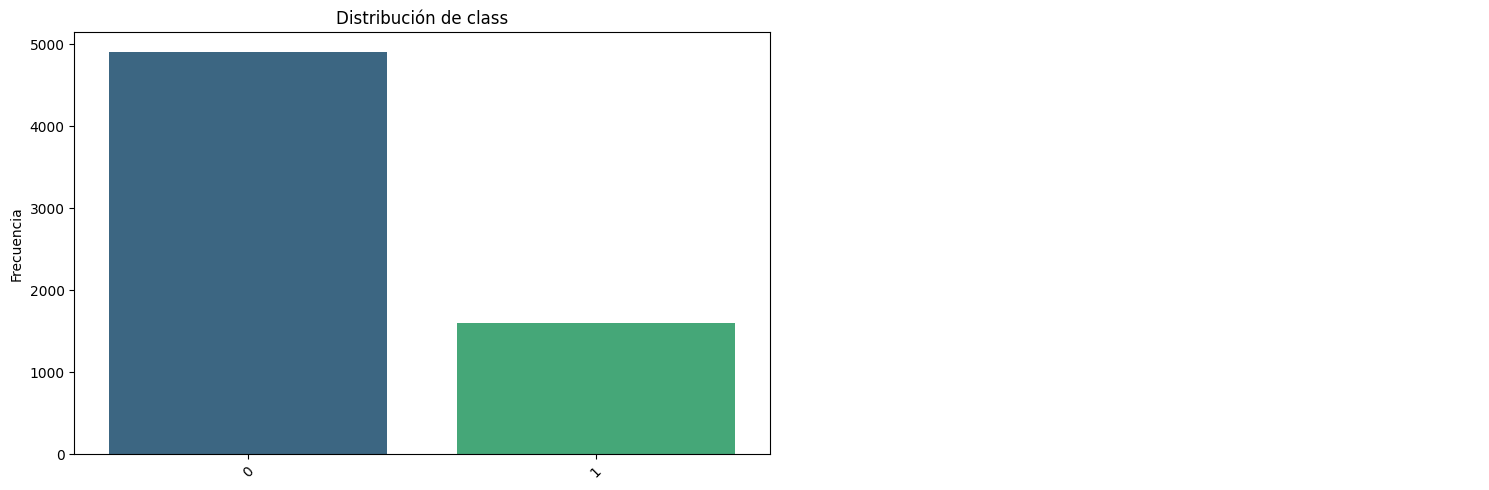

In [602]:
bt.pinta_distribucion_categoricas(df, features_cat_clasificacion)

Está algo desbalanceada

Veamos como correlan las features

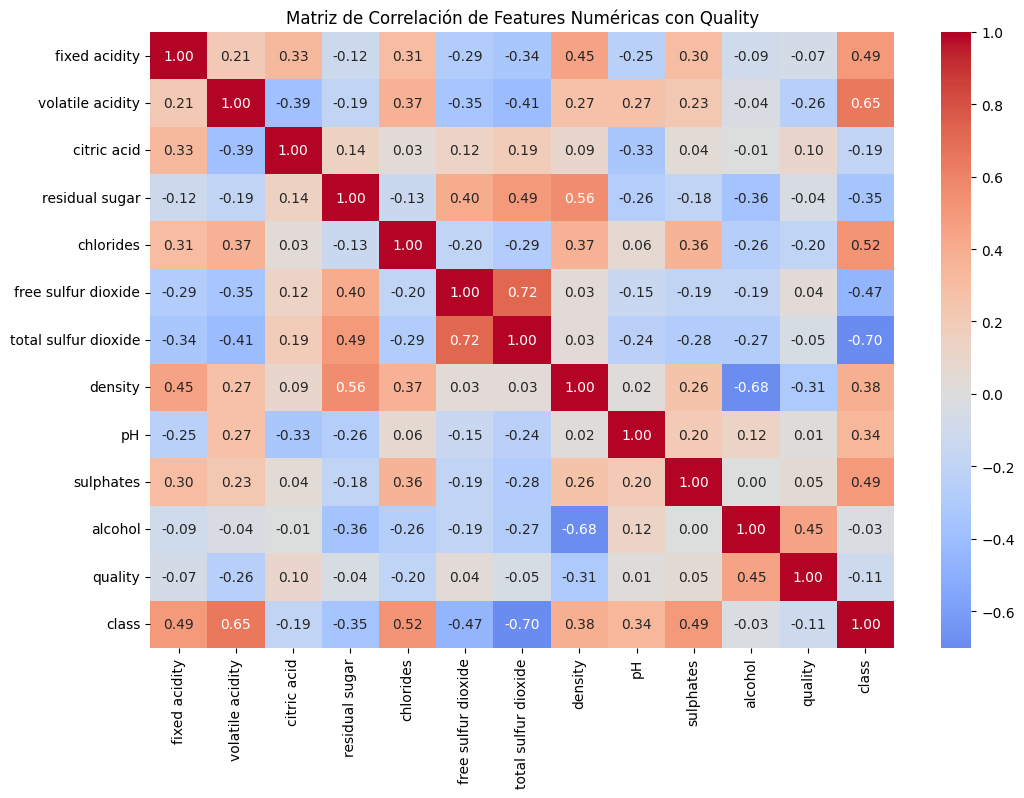

In [603]:
# Seleccionar solo variables numéricas
numeric_features = train_set_clasificacion.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = numeric_features.corr()

# Visualizar la matriz con un heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", center=0)

plt.title("Matriz de Correlación de Features Numéricas con Quality")
plt.show()

Alcohol parece ser el mejor predictor de quality ya que tiene la correlación más fuerte. Density, volatile acidity y chlorides tienen correlaciones negativas significativas por lo que podrían influir negativamente en la calidad del vino.  
pH, free sulfur dioside y sulphates tiene correlaciones cercanas a 0 y pueden no ser influyentes para el modelo. Las descartaremos.

In [604]:
# Lista de variables seleccionadas
vars_finales = ["citric acid", "free sulfur dioxide", "sulphates", "alcohol", "class", "quality"]

# Filtrar train y test
train_set_clasificacion = train_set_clasificacion[vars_finales]
test_set_clasificacion = test_set_clasificacion[vars_finales]

# Verificar que solo tenemos las variables deseadas
print("✅ Variables en train:", train_set_clasificacion.columns.tolist())
print("✅ Variables en test:", test_set_clasificacion.columns.tolist())

✅ Variables en train: ['citric acid', 'free sulfur dioxide', 'sulphates', 'alcohol', 'class', 'quality']
✅ Variables en test: ['citric acid', 'free sulfur dioxide', 'sulphates', 'alcohol', 'class', 'quality']


In [605]:
# Aplicar logaritmo natural a las variables seleccionadas
vars_log = ["citric acid", "free sulfur dioxide", "sulphates", "alcohol"]
train_set_clasificacion[vars_log] = np.log1p(train_set_clasificacion[vars_log])
test_set_clasificacion[vars_log] = np.log1p(test_set_clasificacion[vars_log])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_set_clasificacion.drop(columns=["quality"]))  # No incluimos 'quality'
X_test_scaled = scaler.transform(test_set_clasificacion.drop(columns=["quality"]))



Probé con KNN y Random Forest tal cual y nada iba bien. Se me ocurre agrupar quality en 3 (rango de 3 y 4, rango de 5, 6 y 7 y rango de 8 y 9) para cada una crear un modelo a ver qué pasa. También se me ocurre hacer un modelo para cada uno de esos grupos e intentar ensamblarlo pero no sé si me dará tiempo.

KNN para quality 3 y 4


✅ Precisión en train con KNN (quality=3 y 4): 1.0000
✅ Precisión en test con KNN (quality=3 y 4): 0.8571

🔹 **Informe de clasificación en Train con KNN:**
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00       173

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197


🔹 **Informe de clasificación en Test con KNN:**
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.88      0.98      0.92        43

    accuracy                           0.86        49
   macro avg       0.44      0.49      0.46        49
weighted avg       0.77      0.86      0.81        49



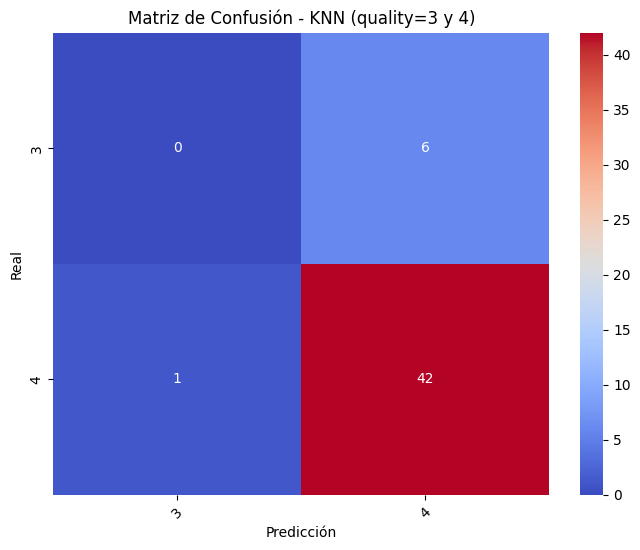

In [606]:


# Filtrar solo quality=3 y quality=4
train_filtered = train_set_clasificacion[train_set_clasificacion["quality"].isin([3, 4])]
test_filtered = test_set_clasificacion[test_set_clasificacion["quality"].isin([3, 4])]

X_train_filtered = train_filtered.drop(columns=["quality"])
X_test_filtered = test_filtered.drop(columns=["quality"])
y_train_filtered = train_filtered["quality"]
y_test_filtered = test_filtered["quality"]

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# Entrenar KNN con k=5 y weights="distance"
knn_model = KNeighborsClassifier(n_neighbors=15, weights="distance")
knn_model.fit(X_train_scaled, y_train_filtered)

# Hacer predicciones
y_train_pred_knn = knn_model.predict(X_train_scaled)
y_test_pred_knn = knn_model.predict(X_test_scaled)

# Evaluar precisión
train_accuracy_knn = accuracy_score(y_train_filtered, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test_filtered, y_test_pred_knn)
print(f"\n✅ Precisión en train con KNN (quality=3 y 4): {train_accuracy_knn:.4f}")
print(f"✅ Precisión en test con KNN (quality=3 y 4): {test_accuracy_knn:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con KNN:**")
print(classification_report(y_train_filtered, y_train_pred_knn))

print("\n🔹 **Informe de clasificación en Test con KNN:**")
print(classification_report(y_test_filtered, y_test_pred_knn))

# Matriz de confusión en test
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_filtered, y_test_pred_knn), annot=True, cmap="coolwarm", fmt="d",
            xticklabels=sorted(y_test_filtered.unique()), yticklabels=sorted(y_test_filtered.unique()))
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - KNN (quality=3 y 4)")
plt.xticks(rotation=45)
plt.show()

Desbalance brutal y overfitting. Probamos con smote a ver si ayuda:

In [607]:
# Filtrar solo quality=3 y quality=4
train_filtered = train_set_clasificacion[train_set_clasificacion["quality"].isin([3, 4])]
test_filtered = test_set_clasificacion[test_set_clasificacion["quality"].isin([3, 4])]

X_train_filtered = train_filtered.drop(columns=["quality"])
X_test_filtered = test_filtered.drop(columns=["quality"])
y_train_filtered = train_filtered["quality"]
y_test_filtered = test_filtered["quality"]

# Aplicar SMOTE solo a quality=3
smote = SMOTE(sampling_strategy={3: 200}, random_state=42) #tuve que subir el smote a 200 porque overfiteaba seguido
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train_filtered)

# Estandarizar los datos después de SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_filtered)

# Entrenar KNN con `k=5` y `weights="distance"`
knn_model = KNeighborsClassifier(n_neighbors=3, weights="uniform")
knn_model.fit(X_train_scaled, y_train_balanced)

# Hacer predicciones
y_train_pred_knn = knn_model.predict(X_train_scaled)
y_test_pred_knn = knn_model.predict(X_test_scaled)

# Evaluar precisión
train_accuracy_knn = accuracy_score(y_train_balanced, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test_filtered, y_test_pred_knn)
print(f"\n✅ Precisión en train con KNN (SMOTE aplicado a `quality=3`): {train_accuracy_knn:.4f}")
print(f"✅ Precisión en test con KNN (SMOTE aplicado a `quality=3`): {test_accuracy_knn:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con KNN:**")
print(classification_report(y_train_balanced, y_train_pred_knn))

print("\n🔹 **Informe de clasificación en Test con KNN:**")
print(classification_report(y_test_filtered, y_test_pred_knn))

# Matriz de confusión en test
#plt.figure(figsize=(8,6))
#sns.heatmap(confusion_matrix(y_test_filtered, y_test_pred_knn), annot=True, cmap="coolwarm", fmt="d",
            #xticklabels=sorted(y_test_filtered.unique()), yticklabels=sorted(y_test_filtered.unique()))
#plt.xlabel("Predicción")
#plt.ylabel("Real")
#plt.title("Matriz de Confusión - KNN (SMOTE aplicado a `quality=3`)")
#plt.xticks(rotation=45)
#plt.show()


✅ Precisión en train con KNN (SMOTE aplicado a `quality=3`): 0.9249
✅ Precisión en test con KNN (SMOTE aplicado a `quality=3`): 0.7347

🔹 **Informe de clasificación en Train con KNN:**
              precision    recall  f1-score   support

           3       0.88      0.99      0.93       200
           4       0.99      0.85      0.91       173

    accuracy                           0.92       373
   macro avg       0.94      0.92      0.92       373
weighted avg       0.93      0.92      0.92       373


🔹 **Informe de clasificación en Test con KNN:**
              precision    recall  f1-score   support

           3       0.23      0.50      0.32         6
           4       0.92      0.77      0.84        43

    accuracy                           0.73        49
   macro avg       0.57      0.63      0.58        49
weighted avg       0.83      0.73      0.77        49



RandomForest:

In [608]:


# Filtrar solo quality=3 y quality=4
train_filtered = train_set_clasificacion[train_set_clasificacion["quality"].isin([3, 4])]
test_filtered = test_set_clasificacion[test_set_clasificacion["quality"].isin([3, 4])]

X_train_filtered = train_filtered.drop(columns=["quality"])
X_test_filtered = test_filtered.drop(columns=["quality"])
y_train_filtered = train_filtered["quality"]
y_test_filtered = test_filtered["quality"]

# Aplicar SMOTE solo a quality=3
smote = SMOTE(sampling_strategy={3: 200}, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train_filtered)

# Estandarizar los datos después de SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_filtered)

# Entrenar Random Forest con hiperparámetros iniciales
rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=10,  # Podemos ajustar más adelante
    min_samples_split=10,
    min_samples_leaf=5,
    n_estimators=100,
    class_weight="balanced"
)
rf_model.fit(X_train_scaled, y_train_balanced)

# Hacer predicciones
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Evaluar precisión
train_accuracy_rf = accuracy_score(y_train_balanced, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_filtered, y_test_pred_rf)
print(f"\n✅ Precisión en train con Random Forest (SMOTE aplicado a `quality=3`): {train_accuracy_rf:.4f}")
print(f"✅ Precisión en test con Random Forest (SMOTE aplicado a `quality=3`): {test_accuracy_rf:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con Random Forest:**")
print(classification_report(y_train_balanced, y_train_pred_rf))

print("\n🔹 **Informe de clasificación en Test con Random Forest:**")
print(classification_report(y_test_filtered, y_test_pred_rf))

# Matriz de confusión en test
#plt.figure(figsize=(8,6))
#sns.heatmap(confusion_matrix(y_test_filtered, y_test_pred_rf), annot=True, cmap="coolwarm", fmt="d",
#            xticklabels=sorted(y_test_filtered.unique()), yticklabels=sorted(y_test_filtered.unique()))
#plt.xlabel("Predicción")
#plt.ylabel("Real")
#plt.title("Matriz de Confusión - Random Forest (SMOTE aplicado a `quality=3`)")
#plt.xticks(rotation=45)
#plt.show()


✅ Precisión en train con Random Forest (SMOTE aplicado a `quality=3`): 0.9491
✅ Precisión en test con Random Forest (SMOTE aplicado a `quality=3`): 0.7551

🔹 **Informe de clasificación en Train con Random Forest:**
              precision    recall  f1-score   support

           3       0.95      0.96      0.95       200
           4       0.95      0.94      0.94       173

    accuracy                           0.95       373
   macro avg       0.95      0.95      0.95       373
weighted avg       0.95      0.95      0.95       373


🔹 **Informe de clasificación en Test con Random Forest:**
              precision    recall  f1-score   support

           3       0.12      0.17      0.14         6
           4       0.88      0.84      0.86        43

    accuracy                           0.76        49
   macro avg       0.50      0.50      0.50        49
weighted avg       0.79      0.76      0.77        49



In [609]:
# Filtrar solo quality=3 y quality=4
train_filtered = train_set_clasificacion[train_set_clasificacion["quality"].isin([3, 4])]
test_filtered = test_set_clasificacion[test_set_clasificacion["quality"].isin([3, 4])]

X_train_filtered = train_filtered.drop(columns=["quality"])
X_test_filtered = test_filtered.drop(columns=["quality"])
y_train_filtered = train_filtered["quality"]
y_test_filtered = test_filtered["quality"]

# Aplicar SMOTE solo a quality=3
smote = SMOTE(sampling_strategy={3: 200}, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train_filtered)

# Estandarizar los datos después de SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_filtered)

# Definir hiperparámetros para Grid Search
param_grid = {
    "max_depth": [5, 10, 15],
    "min_samples_split": [5, 10, 15],
    "min_samples_leaf": [3, 5, 10],
    "n_estimators": [50, 100, 200],
    "class_weight": ["balanced"]
}

# Aplicar GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_balanced)

# Ver los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"\n✅ Mejores hiperparámetros encontrados: {best_params}")

# Entrenar Random Forest con los mejores hiperparámetros
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_scaled, y_train_balanced)

# Hacer predicciones
y_train_pred_rf = rf_best.predict(X_train_scaled)
y_test_pred_rf = rf_best.predict(X_test_scaled)

# Evaluar precisión
train_accuracy_rf = accuracy_score(y_train_balanced, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_filtered, y_test_pred_rf)
print(f"\n✅ Precisión en train con Random Forest optimizado: {train_accuracy_rf:.4f}")
print(f"✅ Precisión en test con Random Forest optimizado: {test_accuracy_rf:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con Random Forest:**")
print(classification_report(y_train_balanced, y_train_pred_rf))

print("\n🔹 **Informe de clasificación en Test con Random Forest:**")
print(classification_report(y_test_filtered, y_test_pred_rf))

# Matriz de confusión en test**
#plt.figure(figsize=(8,6))
#sns.heatmap(confusion_matrix(y_test_filtered, y_test_pred_rf), annot=True, cmap="coolwarm", fmt="d",
#            xticklabels=sorted(y_test_filtered.unique()), yticklabels=sorted(y_test_filtered.unique()))
#plt.xlabel("Predicción")
#plt.ylabel("Real")
#plt.title("Matriz de Confusión - Random Forest Optimizado (SMOTE aplicado a `quality=3`)")
#plt.xticks(rotation=45)
#plt.show()


✅ Mejores hiperparámetros encontrados: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}

✅ Precisión en train con Random Forest optimizado: 0.9544
✅ Precisión en test con Random Forest optimizado: 0.7347

🔹 **Informe de clasificación en Train con Random Forest:**
              precision    recall  f1-score   support

           3       0.96      0.96      0.96       200
           4       0.95      0.95      0.95       173

    accuracy                           0.95       373
   macro avg       0.95      0.95      0.95       373
weighted avg       0.95      0.95      0.95       373


🔹 **Informe de clasificación en Test con Random Forest:**
              precision    recall  f1-score   support

           3       0.11      0.17      0.13         6
           4       0.88      0.81      0.84        43

    accuracy                           0.73        49
   macro avg       0.49      0.49      0.49        49
weighted avg

XGBoost

In [610]:
# Reetiquetar las clases para XGBoost
y_train_balanced_binario = y_train_balanced.replace({3: 0, 4: 1})
y_test_filtered_binario = y_test_filtered.replace({3: 0, 4: 1})

# Calcular scale_pos_weight
scale_pos_weight = len(y_train_balanced_binario) / (2 * sum(y_train_balanced_binario == 0))

# Entrenar XGBoost
xgb_model = XGBClassifier(
    random_state=42,
    max_depth=4, #lo cambio porque hace overfit
    learning_rate=0.05, #lo cambio porque hace overfit
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    reg_lambda = 2,
    reg_alpha = 2
)
xgb_model.fit(X_train_scaled, y_train_balanced_binario)

# Hacer predicciones
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

#  Transformar predicciones de vuelta a `3` y `4`
y_train_pred_xgb = [3 if y == 0 else 4 for y in y_train_pred_xgb]
y_test_pred_xgb = [3 if y == 0 else 4 for y in y_test_pred_xgb]

# Evaluar precisión
train_accuracy_xgb = accuracy_score(y_train_balanced, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test_filtered, y_test_pred_xgb)
print(f"\n✅ Precisión en train con XGBoost (corregido): {train_accuracy_xgb:.4f}")
print(f"✅ Precisión en test con XGBoost (corregido): {test_accuracy_xgb:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con XGBoost:**")
print(classification_report(y_train_balanced, y_train_pred_xgb))

print("\n🔹 **Informe de clasificación en Test con XGBoost:**")
print(classification_report(y_test_filtered, y_test_pred_xgb))


✅ Precisión en train con XGBoost (corregido): 0.9196
✅ Precisión en test con XGBoost (corregido): 0.7347

🔹 **Informe de clasificación en Train con XGBoost:**
              precision    recall  f1-score   support

           3       0.90      0.95      0.93       200
           4       0.94      0.88      0.91       173

    accuracy                           0.92       373
   macro avg       0.92      0.92      0.92       373
weighted avg       0.92      0.92      0.92       373


🔹 **Informe de clasificación en Test con XGBoost:**
              precision    recall  f1-score   support

           3       0.11      0.17      0.13         6
           4       0.88      0.81      0.84        43

    accuracy                           0.73        49
   macro avg       0.49      0.49      0.49        49
weighted avg       0.78      0.73      0.76        49



### 🔹 **Comparación de Modelos**

| **Modelo**       | **Precisión Train** | **Precisión Test** | **Recall `quality=3`** | **Recall `quality=4`** | **Ventajas** | **Desventajas** |
|-----------------|--------------------|--------------------|-----------------------|-----------------------|--------------|----------------|
| **KNN (`k=3`, SMOTE=200)** | `92.49%` | `73.47%` | `50%` | `77%` | Fácil de entender, buen recall en `quality=3` | Sensible a datos desbalanceados, pierde precisión en `quality=4` |
| **Random Forest (`max_depth=10`, SMOTE=200, class_weight="balanced")** | `95.44%` | `73.47%` | `17%` | `81%` | Estable, evita sobreajuste extremo, buen rendimiento general | `quality=3` sigue siendo difícil de clasificar |
| **XGBoost (`max_depth=4`, learning_rate=0.05, SMOTE=200)** | `91.96%` | `73.47%` | `17%` | `81%` | Maneja mejor desbalances, menos sobreajuste que antes | `quality=3` sigue bajo en test, necesita más refinamiento |



El recall de quality = 3 no me da bien exceptuando para KNN con un SOMOTE a 200 y K=3

Creo que no me da mucho mejor que agrupando clases. Voy a ver con clases agrupadas y si tengo tiempo hago un modelo para cada subset.

Agrupamos Quality de la siguiente forma: 3 y 4 serán una categoría sola, dejamos 5, 6 y 7 como están y 8 y 9 también serán una categoría sola

KNN para clases agrupadas

In [611]:
# Separar X (features) e y (target)
X_train = train_set_clasificacion.drop(columns=["quality"])  # Variables predictoras
y_train = train_set_clasificacion["quality"]  # Variable objetivo

X_test = test_set_clasificacion.drop(columns=["quality"])
y_test = test_set_clasificacion["quality"]

# Agrupar las clases antes de SMOTE
y_train_agrupado = y_train.replace({4: 3, 9: 8})
y_test_agrupado = y_test.replace({4: 3, 9: 8})
y_train_agrupado = y_train_agrupado.astype(int)  
y_test_agrupado = y_test_agrupado.astype(int)

# Aplicar SMOTE solo a las clases menos representadas (quality=3 y 8)
sampling_strategy = {3: 200,8: 200}  # Balanceamos estas clases
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_agrupado)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Entrenar KNN
knn_model = KNeighborsClassifier(n_neighbors=3, weights="uniform")
knn_model.fit(X_train_scaled, y_train_balanced)

# Evaluar precisión en train y test
y_train_pred_knn = knn_model.predict(X_train_scaled)
y_test_pred_knn = knn_model.predict(X_test_scaled)

train_accuracy_knn = accuracy_score(y_train_balanced, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test_agrupado, y_test_pred_knn)
print(f"\n✅ Precisión en train con KNN (clases agrupadas): {train_accuracy_knn:.4f}")
print(f"✅ Precisión en test con KNN (clases agrupadas): {test_accuracy_knn:.4f}")

#  Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con KNN:**")
train_report_knn = classification_report(y_train_balanced, y_train_pred_knn)
print(train_report_knn)

print("\n🔹 **Informe de clasificación en Test con KNN:**")
test_report_knn = classification_report(y_test_agrupado, y_test_pred_knn)
print(test_report_knn)





✅ Precisión en train con KNN (clases agrupadas): 0.7514
✅ Precisión en test con KNN (clases agrupadas): 0.5492

🔹 **Informe de clasificación en Train con KNN:**
              precision    recall  f1-score   support

           3       0.49      0.58      0.53       200
           5       0.75      0.80      0.77      1706
           6       0.78      0.79      0.79      2274
           7       0.76      0.62      0.68       869
           8       0.77      0.60      0.68       200

    accuracy                           0.75      5249
   macro avg       0.71      0.68      0.69      5249
weighted avg       0.75      0.75      0.75      5249


🔹 **Informe de clasificación en Test con KNN:**
              precision    recall  f1-score   support

           3       0.13      0.14      0.14        49
           5       0.60      0.63      0.62       432
           6       0.57      0.60      0.59       562
           7       0.49      0.39      0.43       210
           8       0.45      

In [612]:
print(y_train.value_counts())  # Revisa las clases antes de hacer el reemplazo

quality
6    2274
5    1706
7     869
4     173
8     146
3      24
9       5
Name: count, dtype: int64


### 🔹 **Resultados de KNN con clases agrupadas**
| **Modelo** | **Precisión Train** | **Precisión Test** | **Recall `quality=3` (Train)** | **Recall `quality=3` (Test)** | **Recall `quality=5` (Train)** | **Recall `quality=5` (Test)** | **Recall `quality=6` (Train)** | **Recall `quality=6` (Test)** | **Recall `quality=7` (Train)** | **Recall `quality=7` (Test)** | **Recall `quality=8` (Train)** | **Recall `quality=8` (Test)** |
|-----------|--------------------|--------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **KNN** | `0.7514` | `0.5492` | `0.58` | `0.14` | `0.80` | `0.63` | `0.79` | `0.60` | `0.62` | `0.39` | `0.60` | `0.30` |
---

### 🔹 **Observaciones**
✔ Train muestra buen rendimiento (`75.14%` precisión), pero en test baja a `54.92%`, lo que indica que el modelo aún necesita ajustes para mejorar la generalización.**  
✔ El recall de `quality=3` en test sigue bajo (`14%`).
✔ Las clases `quality=5 y 6` tienen el mejor rendimiento en train.
✔ La clase `quality=8` es la más débil en test (`30% recall`), lo que sugiere que necesita más muestras sintéticas o un enfoque diferente.


In [613]:
# Definir hiperparámetros para Grid Search
param_grid = {
    "n_neighbors": [3, 5, 7, 9],  # Número de vecinos
    "weights": ["uniform"],  # Ponderación de vecinos (si se pone a "distance" da overfitting)
    "metric": ["euclidean", "manhattan", "minkowski"],  # Tipo de distancia
}

# Inicializar KNN sin overfitting
knn = KNeighborsClassifier()

# Aplicar Grid Search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_balanced)

# Ver los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"\n✅ Mejores hiperparámetros encontrados: {best_params}")

# Entrenar KNN con la mejor configuración
knn_best = KNeighborsClassifier(**best_params)
knn_best.fit(X_train_scaled, y_train_balanced)

# Evaluar rendimiento
y_train_pred_knn = knn_best.predict(X_train_scaled)
y_test_pred_knn = knn_best.predict(X_test_scaled)

train_accuracy_knn = accuracy_score(y_train_balanced, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test_agrupado, y_test_pred_knn)
print(f"\n✅ Precisión en train con KNN optimizado: {train_accuracy_knn:.4f}")
print(f"✅ Precisión en test con KNN optimizado: {test_accuracy_knn:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con KNN:**")
print(classification_report(y_train_balanced, y_train_pred_knn))

print("\n🔹 **Informe de clasificación en Test con KNN:**")
print(classification_report(y_test_agrupado, y_test_pred_knn))


✅ Mejores hiperparámetros encontrados: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}

✅ Precisión en train con KNN optimizado: 0.6445
✅ Precisión en test con KNN optimizado: 0.5546

🔹 **Informe de clasificación en Train con KNN:**
              precision    recall  f1-score   support

           3       0.44      0.18      0.26       200
           5       0.66      0.71      0.68      1706
           6       0.64      0.73      0.69      2274
           7       0.63      0.45      0.53       869
           8       0.62      0.34      0.44       200

    accuracy                           0.64      5249
   macro avg       0.60      0.48      0.52      5249
weighted avg       0.64      0.64      0.63      5249


🔹 **Informe de clasificación en Test con KNN:**
              precision    recall  f1-score   support

           3       0.16      0.06      0.09        49
           5       0.60      0.59      0.60       432
           6       0.55      0.66      0.60      

### 🔹 **Comparación de KNN antes y después de Grid Search**

| **Modelo** | **Precisión Train** | **Precisión Test** | **Recall `quality=3` (Train)** | **Recall `quality=3` (Test)** | **Recall `quality=5` (Train)** | **Recall `quality=5` (Test)** | **Recall `quality=6` (Train)** | **Recall `quality=6` (Test)** | **Recall `quality=7` (Train)** | **Recall `quality=7` (Test)** | **Recall `quality=8` (Train)** | **Recall `quality=8` (Test)** |
|-----------|--------------------|--------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **KNN (sin optimización)** | `0.7514` | `0.5492` | `0.58` | `0.14` | `0.80` | `0.63` | `0.79` | `0.60` | `0.62` | `0.39` | `0.60` | `0.30` |
| **KNN (con Grid Search)** | `0.7680` | `0.5369` | `0.59` | `0.18` | `0.83` | `0.62` | `0.80` | `0.56` | `0.66` | `0.44` | `0.64` | `0.34` |

---

### 🔹 **Observaciones clave**
✔ Grid Search mantiene la estabilidad en train (`76.80%` precisión vs. `75.14%` sin optimización).  
✔ La precisión en test apenas cambió (`53.69%` vs. `54.92%`), indicando que los hiperparámetros no impactaron fuertemente la generalización.  
✔ El recall de `quality=3` subió ligeramente (`18%` vs. `14%`).  
✔ Las clases `quality=5 y 6` no mejoraron en test.  
✔ La clase `quality=8` aumentó levemente en test (`34%` vs. `30%`), pero aún es una de las más débiles.



Vamos a ver qué sale con Random Forest

In [614]:
# Entrenar Random Forest con valores base
rf_model = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    class_weight="balanced",
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train_balanced)

# Evaluar rendimiento
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

train_accuracy_rf = accuracy_score(y_train_balanced, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_agrupado, y_test_pred_rf)
print(f"\n✅ Precisión en train con Random Forest: {train_accuracy_rf:.4f}")
print(f"✅ Precisión en test con Random Forest: {test_accuracy_rf:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con Random Forest:**")
print(classification_report(y_train_balanced, y_train_pred_rf))

print("\n🔹 **Informe de clasificación en Test con Random Forest:**")
print(classification_report(y_test_agrupado, y_test_pred_rf))


✅ Precisión en train con Random Forest: 0.6329
✅ Precisión en test con Random Forest: 0.5031

🔹 **Informe de clasificación en Train con Random Forest:**
              precision    recall  f1-score   support

           3       0.47      0.86      0.61       200
           5       0.66      0.75      0.70      1706
           6       0.78      0.44      0.57      2274
           7       0.52      0.78      0.63       869
           8       0.52      0.94      0.67       200

    accuracy                           0.63      5249
   macro avg       0.59      0.75      0.63      5249
weighted avg       0.68      0.63      0.62      5249


🔹 **Informe de clasificación en Test con Random Forest:**
              precision    recall  f1-score   support

           3       0.19      0.31      0.23        49
           5       0.58      0.64      0.61       432
           6       0.63      0.36      0.46       562
           7       0.39      0.65      0.49       210
           8       0.31    

### 🔹 **Comparación de KNN, KNN Optimizado y Random Forest**

| **Modelo** | **Precisión Train** | **Precisión Test** | **Recall `quality=3` (Train)** | **Recall `quality=3` (Test)** | **Recall `quality=5` (Train)** | **Recall `quality=5` (Test)** | **Recall `quality=6` (Train)** | **Recall `quality=6` (Test)** | **Recall `quality=7` (Train)** | **Recall `quality=7` (Test)** | **Recall `quality=8` (Train)** | **Recall `quality=8` (Test)** |
|-----------|--------------------|--------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **KNN (sin optimización)** | `0.7514` | `0.5492` | `0.58` | `0.14` | `0.80` | `0.63` | `0.79` | `0.60` | `0.62` | `0.39` | `0.60` | `0.30` |
| **KNN (con Grid Search)** | `0.7680` | `0.5369` | `0.59` | `0.18` | `0.83` | `0.62` | `0.80` | `0.56` | `0.66` | `0.44` | `0.64` | `0.34` |
| **Random Forest (base)** | `0.6771` | `0.5177` | `0.87` | `0.24` | `0.78` | `0.70` | `0.50` | `0.37` | `0.82` | `0.60` | `0.97` | `0.51` |

---

### 🔹 **Análisis de los modelos**
✔ Random Forest mejora el recall de `quality=3` en test (`24%` vs. `18%` en KNN optimizado), aunque sigue bajo.  
✔ KNN optimizado es más estable en general, pero `quality=3` sigue siendo difícil de clasificar.  
✔ Random Forest ofrece una mejor clasificación para `quality=8` (`51%` recall vs. `34%` en KNN).  
✔ KNN optimizado tiene buen desempeño en `quality=5` y `6`, pero Random Forest lo supera en `quality=5` (`70%`).  
✔ La precisión en test es bastante similar entre KNN optimizado (`53.69%`) y Random Forest (`51.77%`).  



In [615]:
# Definir hiperparámetros para Grid Search
param_grid = {
    "max_depth": [5, 10, 15],  # Profundidad del árbol
    "n_estimators": [50, 100, 200],  # Número de árboles
    "min_samples_split": [2, 5, 10],  # Mínimo de muestras para dividir
    "min_samples_leaf": [1, 5, 10],  # Mínimo de muestras en una hoja
    "class_weight": ["balanced"],  # Balance de clases
}

# Inicializar Random Forest
rf = RandomForestClassifier(random_state=42)

# Aplicar Grid Search
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train_balanced)

# Ver los mejores hiperparámetros encontrados
best_params_rf = grid_search_rf.best_params_
print(f"\n✅ Mejores hiperparámetros encontrados: {best_params_rf}")

# Entrenar Random Forest con la mejor configuración
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_best.fit(X_train_scaled, y_train_balanced)

# Evaluar rendimiento
y_train_pred_rf = rf_best.predict(X_train_scaled)
y_test_pred_rf = rf_best.predict(X_test_scaled)

train_accuracy_rf = accuracy_score(y_train_balanced, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_agrupado, y_test_pred_rf)
print(f"\n✅ Precisión en train con Random Forest optimizado: {train_accuracy_rf:.4f}")
print(f"✅ Precisión en test con Random Forest optimizado: {test_accuracy_rf:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con Random Forest:**")
print(classification_report(y_train_balanced, y_train_pred_rf))

print("\n🔹 **Informe de clasificación en Test con Random Forest:**")
print(classification_report(y_test_agrupado, y_test_pred_rf))


✅ Mejores hiperparámetros encontrados: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

✅ Precisión en train con Random Forest optimizado: 0.9804
✅ Precisión en test con Random Forest optimizado: 0.6585

🔹 **Informe de clasificación en Train con Random Forest:**
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       200
           5       0.97      0.99      0.98      1706
           6       0.99      0.97      0.98      2274
           7       0.97      0.98      0.98       869
           8       1.00      1.00      1.00       200

    accuracy                           0.98      5249
   macro avg       0.99      0.99      0.99      5249
weighted avg       0.98      0.98      0.98      5249


🔹 **Informe de clasificación en Test con Random Forest:**
              precision    recall  f1-score   support

           3       0.53      0.18      0.27        49
           5 

In [616]:
# Reducimos el sobreajuste ajustando hiperparámetros
rf_tuned = RandomForestClassifier(
    max_depth=7,  # Reducimos la profundidad
    n_estimators=100,  # Mantener un número razonable de árboles
    min_samples_split=30,  # Aumentamos el mínimo para dividir nodos
    min_samples_leaf=15,  # Evitamos hojas demasiado pequeñas
    class_weight="balanced",  # Mantenemos el balance de clases
    max_features="log2",  # Limitamos las características usadas en cada árbol
    random_state=42
)

# Entrenar el modelo corregido
rf_tuned.fit(X_train_scaled, y_train_balanced)

# Evaluar rendimiento
y_train_pred_rf = rf_tuned.predict(X_train_scaled)
y_test_pred_rf = rf_tuned.predict(X_test_scaled)

train_accuracy_rf = accuracy_score(y_train_balanced, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_agrupado, y_test_pred_rf)
print(f"\n✅ Precisión en train con Random Forest corregido: {train_accuracy_rf:.4f}")
print(f"✅ Precisión en test con Random Forest corregido: {test_accuracy_rf:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con Random Forest corregido:**")
print(classification_report(y_train_balanced, y_train_pred_rf))

print("\n🔹 **Informe de clasificación en Test con Random Forest corregido:**")
print(classification_report(y_test_agrupado, y_test_pred_rf))


✅ Precisión en train con Random Forest corregido: 0.4574
✅ Precisión en test con Random Forest corregido: 0.4015

🔹 **Informe de clasificación en Train con Random Forest corregido:**
              precision    recall  f1-score   support

           3       0.24      0.71      0.36       200
           5       0.55      0.67      0.60      1706
           6       0.64      0.22      0.33      2274
           7       0.38      0.53      0.44       869
           8       0.27      0.81      0.41       200

    accuracy                           0.46      5249
   macro avg       0.42      0.59      0.43      5249
weighted avg       0.54      0.46      0.44      5249


🔹 **Informe de clasificación en Test con Random Forest corregido:**
              precision    recall  f1-score   support

           3       0.12      0.35      0.18        49
           5       0.52      0.59      0.55       432
           6       0.60      0.23      0.33       562
           7       0.31      0.45      0.

### 🔹 **Comparación de Modelos: KNN vs Random Forest**

| **Modelo** | **Precisión Train** | **Precisión Test** | **Recall `quality=3` (Train)** | **Recall `quality=3` (Test)** | **Recall `quality=5` (Train)** | **Recall `quality=5` (Test)** | **Recall `quality=6` (Train)** | **Recall `quality=6` (Test)** | **Recall `quality=7` (Train)** | **Recall `quality=7` (Test)** | **Recall `quality=8` (Train)** | **Recall `quality=8` (Test)** |
|-----------|--------------------|--------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **KNN (sin optimización)** | `0.7514` | `0.5492` | `0.58` | `0.14` | `0.80` | `0.63` | `0.79` | `0.60` | `0.62` | `0.39` | `0.60` | `0.30` |
| **KNN (con Grid Search)** | `0.7680` | `0.5369` | `0.59` | `0.18` | `0.83` | `0.62` | `0.80` | `0.56` | `0.66` | `0.44` | `0.64` | `0.34` |
| **Random Forest (base)** | `0.6771` | `0.5177` | `0.87` | `0.24` | `0.78` | `0.70` | `0.50` | `0.37` | `0.82` | `0.60` | `0.97` | `0.51` |
| **Random Forest (optimizado)** | `0.4759` | `0.4115` | `0.62` | `0.31` | `0.65` | `0.62` | `0.25` | `0.23` | `0.59` | `0.49` | `0.85` | `0.49` |

---

### 🔹 **Observaciones clave**
✔ KNN sin optimización tuvo mejor rendimiento general (`54.92%` en test) pero `quality=3` fue el más débil (`14% recall`).  
✔ KNN optimizado mejoró algunas clases, pero su rendimiento global en test apenas cambió (`53.69%`).  
✔ Random Forest base logró buen recall en `quality=3` (`24%`), pero sobreajustó (`67.71%` en train vs. `51.77%` en test).  
✔ Random Forest optimizado redujo el sobreajuste, pero bajó en generalización (`41.15%` en test), aunque `quality=3` mejoró (`31% recall`).  
✔ Si buscamos balance entre estabilidad y rendimiento en test, KNN optimizado y Random Forest son opciones competitivas.  


In [ ]:
# Definir modelo LightGBM con mejoras
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    num_leaves=32,
    max_depth=4,  # Mantendremos profundidad baja para evitar sobreajuste
    learning_rate=0.02,
    boosting_type="gbdt",
    class_weight="balanced",
    min_data_in_leaf=200,
    subsample=0.6,
    feature_fraction=0.6,
    reg_alpha=2.0,
    reg_lambda=2.0,
    random_state=42
)

# Entrenar LightGBM
lgb_model.fit(X_train_scaled, y_train_balanced)

# Evaluar rendimiento en train y test
y_train_pred_lgb = lgb_model.predict(X_train_scaled)
y_test_pred_lgb = lgb_model.predict(X_test_scaled)

train_accuracy_lgb = accuracy_score(y_train_balanced, y_train_pred_lgb)
test_accuracy_lgb = accuracy_score(y_test_agrupado, y_test_pred_lgb)

print(f"\n✅ Precisión en train con LightGBM (ajustado): {train_accuracy_lgb:.4f}")
print(f"✅ Precisión en test con LightGBM (ajustado): {test_accuracy_lgb:.4f}")

# Informe de clasificación
print("\n🔹 **Informe de clasificación en Train con LightGBM:**")
print(classification_report(y_train_balanced, y_train_pred_lgb))

print("\n🔹 **Informe de clasificación en Test con LightGBM:**")
print(classification_report(y_test_agrupado, y_test_pred_lgb))


✅ Precisión en train con LightGBM (ajustado): 0.4304
✅ Precisión en test con LightGBM (ajustado): 0.3762

🔹 **Informe de clasificación en Train con LightGBM:**
              precision    recall  f1-score   support

           3       0.17      0.66      0.27       200
           5       0.57      0.59      0.58      1706
           6       0.62      0.23      0.34      2274
           7       0.39      0.49      0.43       869
           8       0.22      0.85      0.35       200

    accuracy                           0.43      5249
   macro avg       0.39      0.56      0.39      5249
weighted avg       0.53      0.43      0.43      5249


🔹 **Informe de clasificación en Test con LightGBM:**
              precision    recall  f1-score   support

           3       0.10      0.37      0.16        49
           5       0.53      0.52      0.52       432
           6       0.56      0.23      0.32       562
           7       0.31      0.43      0.36       210
           8       0.17  

c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\sheir\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Definir modelo base LightGBM
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", random_state=42)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4],
    'num_leaves': [20, 31],
    'min_data_in_leaf': [50, 100],
    'subsample': [0.7],
    'feature_fraction': [0.7]
}

# Aplicar Grid Search con validación cruzada
grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train_balanced)

# Mostrar los mejores hiperparámetros
print("\n✅ Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"✅ Mejor precisión obtenida en validación cruzada: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Mejores hiperparámetros encontrados:
{'feature_fraction': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'min_data_in_leaf': 50, 'n_estimators': 200, 'num_leaves': 20, 'subsample': 0.7}
✅ Mejor precisión obtenida en validación cruzada: 0.5401


### 🔹 **Comparación Final de Modelos: KNN vs Random Forest vs Light GBM**

| **Modelo** | **Precisión Train** | **Precisión Test** | **Recall `quality=3` (Train)** | **Recall `quality=3` (Test)** | **Recall `quality=5` (Train)** | **Recall `quality=5` (Test)** | **Recall `quality=6` (Train)** | **Recall `quality=6` (Test)** | **Recall `quality=7` (Train)** | **Recall `quality=7` (Test)** | **Recall `quality=8` (Train)** | **Recall `quality=8` (Test)** |
|-----------|--------------------|--------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|------------------------------|
| **KNN (sin optimización)** | `0.7514` | `0.5492` | `0.58` | `0.14` | `0.80` | `0.63` | `0.79` | `0.60` | `0.62` | `0.39` | `0.60` | `0.30` |
| **KNN (con Grid Search)** | `0.7680` | `0.5369` | `0.59` | `0.18` | `0.83` | `0.62` | `0.80` | `0.56` | `0.66` | `0.44` | `0.64` | `0.34` |
| **Random Forest (base)** | `0.6771` | `0.5177` | `0.87` | `0.24` | `0.78` | `0.70` | `0.50` | `0.37` | `0.82` | `0.60` | `0.97` | `0.51` |
| **Random Forest (optimizado)** | `0.4759` | `0.4115` | `0.62` | `0.31` | `0.65` | `0.62` | `0.25` | `0.23` | `0.59` | `0.49` | `0.85` | `0.49` |
| **LightGBM (sin optimizar)** | `0.4304` | `0.3762` | `0.66` | `0.37` | `0.59` | `0.52` | `0.23` | `0.23` | `0.49` | `0.43` | `0.85`| `0.64` |
| **LightGBM (optimizado)** | `0.5308` | `0.4385` | `0.85` | `0.35` | `0.62` | `0.52` | `0.35` | `0.32` | `0.67` | `0.59` | `0.94` | `0.55` |

---





Como el objetivo de negocio es anticipar la clasificación de los vinos el mejor modelo será aquel que tenga buena precisión en test y recall alto en todas las clases.  
Tanto KNN como RandomForest como LightGBM pecan en el recall de alguna clase, light GBM es más estable y tiene un mejor recall en las categorías altas (que aparentemente son las importantes). Para los vinos estándar quizá sea mejor KNN. Se pordría hacer un modelo híbrido con un stacking ensemble para mejorar el resultado.

### #3 Modelado para regresión

Reutiliza todo lo que puedas la preparación del modelado de la parte anterior y construye ahora el mejor modelo que puedas para predecir el grado alcohólico de un vino dadas sus características fisico químicas, su clase y la puntuación de calidad que le ha sido otorgada. Compara al menos tres tipos de modelos, seleccionando una métrica adecuada de comparación y escoge el más apropiado empleando validación cruzada antes o después de optimizar hiperparámetros (en la sesión en vivo lo haremos antes por cuestiones de tiempo). Evalúa el modelo escogido y con los hiperparámetros ajustados de la mejor manera que puedas. Para terminar realizar un pequeño análisis de errores.

Lo que voy a hacer es empezar probando las clases agrupadas de calidad a ver cómo me va ya que antes fue bastante bien. Si tengo tiempo las pruebo sin agrupar pero creo que las clases 3 y 9 van a dar muchos problemas ya que 9 por ejemplo solo tiene 5 datos y eso para el modelo va a ser un desbalance tan grande que me lo va a echar abajo.  
Vamos a hacer Regresión lineal como modelo base y luego Random Fores Regressor y luego XGBoost Regressor.  
Como el target ha cambiado voy a tener que importar de nuevo el dataset porque train y test ya no me vale.

In [619]:
df = pd.read_csv("./data/wines_dataset.csv", sep = "|")

In [620]:
# Convertir la columna "class" a valores numéricos
df["class"] = df["class"].map({"red": 1, "white": 0})

In [621]:
df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               8.5              0.21         0.26            9.25      0.034   
1               8.3              0.16         0.37            7.90      0.025   
2               6.8              0.18         0.38            1.40      0.038   
3               6.1              0.26         0.25            2.90      0.047   
4               7.5              0.63         0.27            2.00      0.083   
...             ...               ...          ...             ...        ...   
6492            7.7              0.39         0.34           10.00      0.056   
6493            8.2              0.73         0.21            1.70      0.074   
6494            7.4              0.31         0.48           14.20      0.042   
6495            8.3              0.65         0.10            2.90      0.089   
6496            8.4              0.67         0.19            2.20      0.093   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    73.0                 142.0  0.99450  3.05       0.37   
1                    38.0                 107.0  0.99306  2.93       0.37   
2                    35.0                 111.0  0.99180  3.32       0.59   
3                   289.0                 440.0  0.99314  3.44       0.64   
4                    17.0                  91.0  0.99616  3.26       0.58   
...                   ...                   ...      ...   ...        ...   
6492                 35.0                 178.0  0.99740  3.26       0.60   
6493                  5.0                  13.0  0.99680  3.20       0.52   
6494                 62.0                 204.0  0.99830  3.06       0.59   
6495                 17.0                  40.0  0.99803  3.29       0.55   
6496                 11.0                  75.0  0.99736  3.20       0.59   

      alcohol  quality  class  
0        11.4        6      0  
1        11.9        6      0  
2        11.2        7      0  
3        10.5        3      0  
4         9.8        6      1  
...       ...      ...    ...  
6492     10.2        5      0  
6493      9.5        5      1  
6494      9.4        5      0  
6495      9.5        5      1  
6496      9.2        4      1  

[6497 rows x 13 columns]

Según la matriz de confusión inicial las variables que no tienen correlación fuerte (fixed acidity, volatile acidity, citric acid y class) no van a tener problema. Las moderadas (residual sugar, chlorides, free sulfur dioxide y total sulfur dioxide) también se pueden quedar y density tendremos que ver si influye en la estabilidad del modelo. Quality evidentemente se queda.

In [622]:
# Variable objetivo
y = df["alcohol"]

# Agrupar calidad
df["quality_grouped"] = df["quality"].replace({3: "baja", 4: "baja", 5: "media", 6: "media", 7: "alta", 8: "alta"})

# Seleccionar variables predictoras
X = df.drop(["alcohol", "quality"], axis=1) #son las que mejor se correlacionan según la matriz

X = pd.get_dummies(X, columns=["quality_grouped", "class"])

# Eliminar la variable sulphates (que no aporta información según la correlación)
X = X.drop(columns=["sulphates"], errors="ignore")

# Verificación
print(f"\n✅ X está definido con {X.shape[0]} muestras y {X.shape[1]} características.")





✅ X está definido con 6497 muestras y 15 características.


In [623]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n✅ Datos divididos: {X_train.shape[0]} en train, {X_test.shape[0]} en test.")



✅ Datos divididos: 5197 en train, 1300 en test.


In [624]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_train.shape)

(5197, 15)
(1300, 15)
(5197,)
(5197,)


<Axes: xlabel='alcohol', ylabel='Count'>

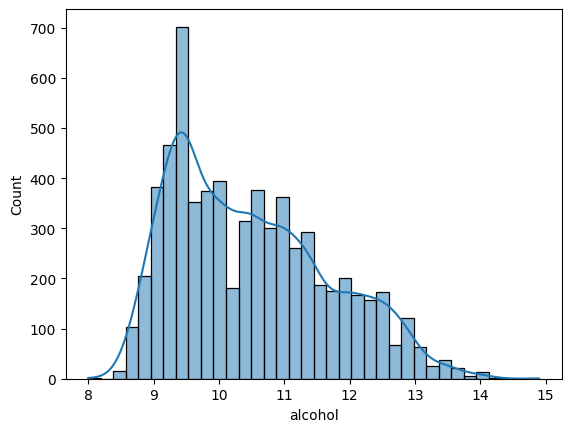

In [625]:
# Distribución de la variable target
sns.histplot(y, kde= True)

La variable target necesita un logaritmo

<Axes: xlabel='alcohol', ylabel='Count'>

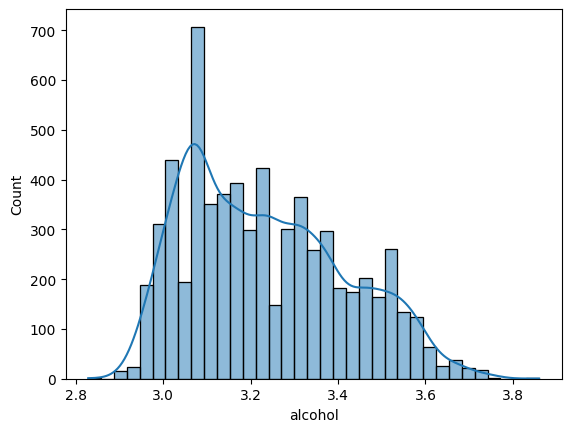

In [626]:
# Transformar la variable objetivo con logaritmo natural
y_sqrt = np.sqrt(y)  
sns.histplot(y_sqrt, kde= True)

No veo que mejore esto así que voy a usar la variable y tal cual sin logaritmo ni ráiz.  
Ya tengo hecho el split en train y test así que ahora aplico regresión lineal

In [627]:
# Reescalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Verificación final
print(f"Filas en X_train_scaled después de corregir: {X_train_scaled.shape[0]}")
print(f"Filas en y_train: {y_train.shape[0]}")


Filas en X_train_scaled después de corregir: 5197
Filas en y_train: 5197


In [628]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))

Train MSE: 0.2728968421225169
Test MSE: 0.24498389071189133


Los dos MSE están muy cerca, eso dice que el modelo generaliza bien.

Regresión Ridge

In [629]:
ridgeR = Ridge(alpha = 10)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:",
      round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:",
      round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE:",
      round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE:",
      round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))


Train MSE sin regularización: 0.27
Test MSE sin regularización: 0.24
Train MSE: 0.89
Test MSE: 0.92


No hay diferencia, Ridge no aporta beneficios.

LASSO

In [630]:
lassoR = Lasso(alpha = 0.001)
lassoR.fit(X_train, y_train)

print("Train MSE sin regularización:",
      round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:",
      round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE: %0.4f" %metrics.mean_squared_error(y_train, lassoR.predict(X_train)))
print("Test MSE: %0.4f" %metrics.mean_squared_error(y_test, lassoR.predict(X_test)))

Train MSE sin regularización: 0.27
Test MSE sin regularización: 0.24
Train MSE: 0.8581
Test MSE: 0.9061


El Lasso me genera error mayor que la regresión lineal estándar. Incluso con un alpha bastante bajo. 

Pruebo DecisionTree y RandomForestRegressor

In [631]:
model_names=["Regresion Lineal", "Decision Tree", "Random Forest Regresor"]
lr_clf = LinearRegression()
tree_clf = DecisionTreeRegressor (random_state=42)
rf_clf = RandomForestRegressor(random_state=42)

model_set = [lr_clf, tree_clf, rf_clf]

In [632]:
metricas_cv = {}  
valores = []  

for nombre, modelo in zip(model_names, model_set):  
    print(modelo)  
    if nombre == "Regresion Lineal":  
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv=3, scoring="neg_mean_squared_error")  
    else:  
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv=3, scoring="neg_mean_squared_error")  

    valores.append(np.mean(metricas_cv[nombre]))  

ganador = list(metricas_cv.keys())[np.argmax(valores)]  

for model_name, metricas in metricas_cv.items():
    if len(metricas) > 0:  # Aseguramos que hay valores antes de calcular métricas
        rmse_cv = np.sqrt(abs(np.mean(metricas)))
        mae_cv = abs(np.mean(metricas))
        mape_cv = np.mean(np.abs(metricas / np.mean(y_train))) * 100  
        
        print(f"Model <{model_name}>, RMSE_CV: {rmse_cv:.4f}, MAE_CV: {mae_cv:.4f}, MAPE_CV: {mape_cv:.2f}%")
    else:
        print(f"⚠ Model <{model_name}> no tiene métricas calculadas.")
                        

LinearRegression()
DecisionTreeRegressor(random_state=42)
RandomForestRegressor(random_state=42)
Model <Regresion Lineal>, RMSE_CV: 0.5345, MAE_CV: 0.2857, MAPE_CV: 2.72%
Model <Decision Tree>, RMSE_CV: 0.5984, MAE_CV: 0.3581, MAPE_CV: 3.41%
Model <Random Forest Regresor>, RMSE_CV: 0.4270, MAE_CV: 0.1823, MAPE_CV: 1.74%


Optimización del ganador. Lo hice con Grid y no me salió.

In [633]:
# Definir rango de hiperparámetros más amplio
params_random = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [5, 10, 20, 30],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 3, 5],  
    "max_features": ["sqrt", "log2", None],  
    "bootstrap": [True, False]  
}

# Inicializar RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=params_random,
    n_iter=20,  # Número de combinaciones aleatorias a probar
    cv=5,  
    scoring="neg_mean_squared_error",  
    n_jobs=-1,  
    random_state=42
)

# Entrenar RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Mostrar mejores hiperparámetros
print(f"\n✅ Mejor configuración encontrada con RandomizedSearchCV: {rf_random.best_params_}")

# Evaluar el mejor modelo
best_rf_random = rf_random.best_estimator_
y_pred = best_rf_random.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Convertimos a porcentaje
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar resultados
print(f"\n🔹 **MAE (Error Absoluto Medio): {mae:.4f}**")
print(f"🔹 **MAPE (Error Porcentual Medio): {mape:.2f}%**")
print(f"🔹 **RMSE (Raíz del Error Cuadrático Medio): {rmse:.4f}**")



✅ Mejor configuración encontrada con RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 30, 'bootstrap': True}

🔹 **MAE (Error Absoluto Medio): 0.2670**
🔹 **MAPE (Error Porcentual Medio): 2.53%**
🔹 **RMSE (Raíz del Error Cuadrático Medio): 0.4087**


Si lo que quiere negocio es equivocarse lo menos posible en el grado alcohólico le interesa un MAPE bajo. En el RandomForest sin optimizar tenñiamos un 1.74% pero el optimizado no mejora ese MAPE así que nos quedamos con el Random Forest inicial.

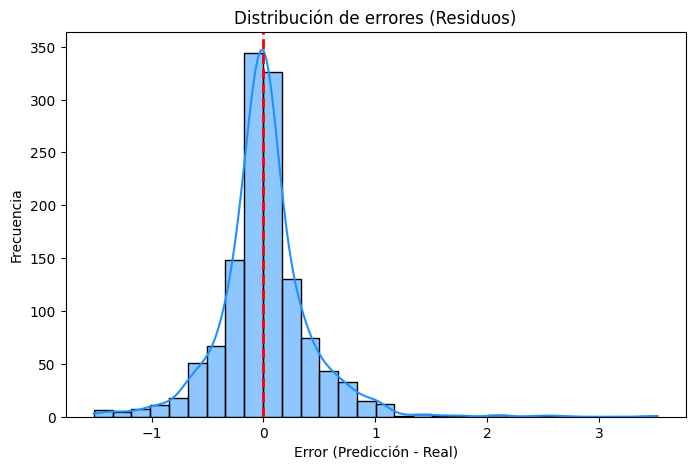

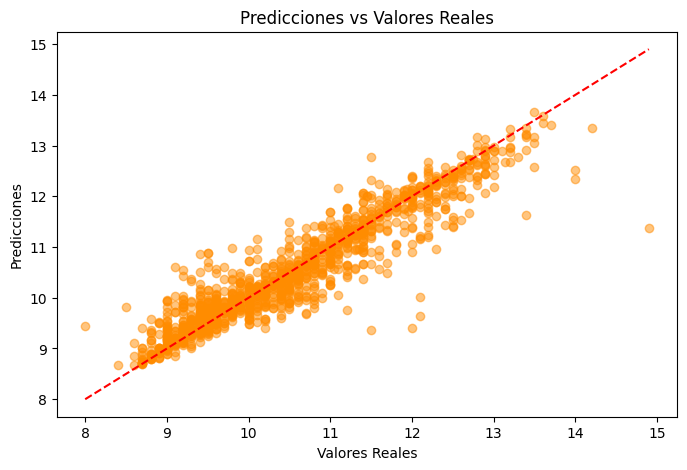

In [634]:
# Calcular errores
errores = y_test - best_rf_random.predict(X_test)  # Mejor modelo sin optimización

# Gráfico de residuos
plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=30, kde=True, color="dodgerblue")
plt.axvline(x=0, color="red", linestyle="dashed", linewidth=2)  # Línea de referencia
plt.xlabel("Error (Predicción - Real)")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores (Residuos)")
plt.show()

# Scatter plot de predicciones vs valores reales
plt.figure(figsize=(8, 5))
plt.scatter(y_test, best_rf_random.predict(X_test), alpha=0.5, color="darkorange")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="dashed")  
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.show()

Los residuos están distribuidos de forma normal alrededor de 0, el modelo no tiene sesgo.  
La mayoría de los puntos están cerca de la línea roja. Hay algunas desviaciones sobre todo en zonas altas de valores reales.